# Terrorist group attribution analysis project 

## Business/Question understanding

##### Before diving into the code, it is important to get the purpose of project clear

##### What are the real-world issues and applications: 
Terrorism is one of the most salient political issues of the 21st century. While some terror groups claim responsibility for attacks, others remain anonymous, making it difficult to attribute culpability for terror incidents. This can in turn make it difficult to set policy agendas and dedicate resources optimally to combating the most dangerous groups.

The Global Terrorism Database (GTD)* records information and attributes on both known and unknown terror attacks across the world. Using this database to build a model which can train (using the known incidents) in order to predict the unknown incidents would therefore be highly valuable as a tool to help attribute culpability for attacks to specific groups. It is hoped that the results of this model could therefore help build policy objectives and allocate anti-terrorism resources in a more evidence-based way. It may also have value for helping understand past historical events for academic and social-justice purposes. 

While the GTD is a global dataset however, it is likely that different regions of the world experience and suffer from terror attacks differently. It is therefore worth taking into consideration that a ‘once-size-fits-all’ approach may not be best for this problem, with different situations on the group and different governments and regional bodies having different requirements. Focusing on a single, highly affected region may therefore give the highest value (especially if that region has many unknown attacks which could be attributed).

The goal of this project will therefore be: 
###### To predict the culpability of terrorist groups for attacks based of the attributes of that attack, in order to help build evidence-based anti-terror policy in areas where this could help reduce attacks most


##### How can this be translated into technical goals:
In technical terms this will be a multi-class (i.e. multiple terrorist groups) classification problem as we want to attribute responsibility for attacks to one of many distinct groups. 

As the GTD records are relatively small (in comparison to say website click-times datasets of potentially billions of records), shallow algorithms are likely to be a good first port of call – both in terms of being able to generalize well and in terms of reduced hardware needs. However depending on the scale and real-world budget of this project, deep learning and powerful server architectures may still be a viable option.

Considering our real-world goals, it is important to also have a relevant performance metric. Because of the potentially deadly implications of informing policy based on this model (e.g. military operations may be directed towards a specific group) it is important that culpability is only attributed to groups when we are confident they are likely to be the true perpetrator. In other words the cost of blaming a group wrongly (False Positive) is a lot worse than not identifying a group that is in fact guilty (False Negative). For this reason, amongst others, Precision seems an intuitively good performance metric, though more will be discussed on this later.  

Moreover, considering the real-world goal of helping set evidence-based policy, then there should not be a massive constraint on the system performance of the model (i.e. attributing responsibility in seconds rather than minutes should not make much difference to setting good policy), though variable server/hardware costs of computationally expensive models may want to be considered. 

Finally we need to remember this is ‘real-world’ data and thus may have quality and definitional issues. In other words the data itself may not always be correct. Moreover the definition, constitution and behaviour of these groups is likely to change over time, suggesting that models would need to be evaluated carefully and retrained regularly to stay relevant to the real-world goal. 


## Setup

### import modules

##### Before we start, let's load the modules we'll need for this analysis. These broadly breakdown into core data manipulation tools (e.g. pandas), dataviz tools (e.g. plotly), machine learning models (e.g. sklearn.linear_model.LogisticRegression), and machine learning pre and post processing helper tools (e.g. confusion_matrix):

In [444]:
# Data manipulation tool kit 
import pandas as pd
import numpy as np
from collections import Counter

# Dataviz tool kit
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
#from matplotlib_venn import venn3
from matplotlib import rcParams
import matplotlib.pyplot as plt 
import seaborn as sns
init_notebook_mode(connected=True)

# Machine learning models kit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn import tree
import xgboost as xgb


# Machine learning helper tools 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import fbeta_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score

# (NLP helper tools)
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# (other system helpers) 
import time
import warnings
warnings.filterwarnings('ignore')


##### It's worth quickly noting that it is good practice to install modules into your (python) project environment to ensure compatible versions can be used across the project and don't create versioning issues in your other environments. For this project Conda Environment was used to this effect.

### Load data

##### Let's also load the raw GTD data directly as it comes (xlsx format) from the online source: https://www.start.umd.edu/gtd/

In [223]:
df = pd.read_excel('globalterrorismdb_0718dist.xlsx')

### explore general data attributes

##### Now the data is loaded, the first thing to do is understand some generic attributes about the data, such as its shape:

In [224]:
data_shape = df.shape
print("the data has {} records and {} fields".format(data_shape[0],data_shape[1]))

the data has 181691 records and 135 fields


##### It is interesting to note the relatively large number of fields (columns) in this dataset. Having so many fields means we will need to carefully go through and understrand each field to assess its potential use in predicting which group is responsible for an attack, as well as whether it needs specific pre-processing of cleaning steps before it can be properly utilized.

##### Because there are so many fields, let's also write a small function so we can see all these fields, their datatypes, and the percentage of Nulls at once to help understand what we are working with... 



In [225]:
def split_dataframe_fields_intro_printable_matrix(df,batch_size = 20):
    index = 0
    single_list = []
    list_of_lists = []
    dfcols_type = df.dtypes.reset_index()
    dfcols_na = df.isnull().sum(axis = 0).reset_index()
    for findex, field in enumerate(list(dfcols_type['index'])):
        info = (field,dfcols_type[0].iloc[findex],round(dfcols_na[0].iloc[findex]/len(df),2))
        index += 1
        single_list.append(info)
        if index > (batch_size - 1):
            list_of_lists.append(single_list)
            single_list = []
            index = 0
    df_fields = pd.DataFrame()
    for index, fields_list in enumerate(list_of_lists):
        df_fields['field_batch_{}'.format(str(index))] = fields_list
    return df_fields

print("All fields in a readable format: ")
split_dataframe_fields_intro_printable_matrix(df,15)

All fields in a readable format: 


field_batch_0                    field_batch_1  \
0                (eventid, int64, 0.0)      (specificity, float64, 0.0)   
1                  (iyear, int64, 0.0)           (vicinity, int64, 0.0)   
2                 (imonth, int64, 0.0)         (location, object, 0.69)   
3                   (iday, int64, 0.0)          (summary, object, 0.36)   
4           (approxdate, object, 0.95)              (crit1, int64, 0.0)   
5               (extended, int64, 0.0)              (crit2, int64, 0.0)   
6   (resolution, datetime64[ns], 0.99)              (crit3, int64, 0.0)   
7                (country, int64, 0.0)        (doubtterr, float64, 0.0)   
8           (country_txt, object, 0.0)     (alternative, float64, 0.84)   
9                 (region, int64, 0.0)  (alternative_txt, object, 0.84)   
10           (region_txt, object, 0.0)         (multiple, float64, 0.0)   
11            (provstate, object, 0.0)            (success, int64, 0.0)   
12                 (city, object, 0.0)            (suicide, int64, 0.0)   
13           (latitude, float64, 0.03)        (attacktype1, int64, 0.0)   
14          (longitude, float64, 0.03)   (attacktype1_txt, object, 0.0)   

                       field_batch_2                     field_batch_3  \
0       (attacktype2, float64, 0.97)  (targsubtype2_txt, object, 0.94)   
1    (attacktype2_txt, object, 0.97)             (corp2, object, 0.94)   
2        (attacktype3, float64, 1.0)           (target2, object, 0.94)   
3     (attacktype3_txt, object, 1.0)          (natlty2, float64, 0.94)   
4            (targtype1, int64, 0.0)       (natlty2_txt, object, 0.94)   
5       (targtype1_txt, object, 0.0)        (targtype3, float64, 0.99)   
6      (targsubtype1, float64, 0.06)     (targtype3_txt, object, 0.99)   
7   (targsubtype1_txt, object, 0.06)     (targsubtype3, float64, 0.99)   
8              (corp1, object, 0.23)  (targsubtype3_txt, object, 0.99)   
9             (target1, object, 0.0)             (corp3, object, 0.99)   
10          (natlty1, float64, 0.01)           (target3, object, 0.99)   
11       (natlty1_txt, object, 0.01)          (natlty3, float64, 0.99)   
12        (targtype2, float64, 0.94)       (natlty3_txt, object, 0.99)   
13     (targtype2_txt, object, 0.94)              (gname, object, 0.0)   
14     (targsubtype2, float64, 0.94)          (gsubname, object, 0.97)   

                    field_batch_4                     field_batch_5  \
0          (gname2, object, 0.99)        (claimmode2, float64, 1.0)   
1        (gsubname2, object, 1.0)     (claimmode2_txt, object, 1.0)   
2           (gname3, object, 1.0)            (claim3, float64, 1.0)   
3        (gsubname3, object, 1.0)        (claimmode3, float64, 1.0)   
4          (motive, object, 0.72)     (claimmode3_txt, object, 1.0)   
5     (guncertain1, float64, 0.0)        (compclaim, float64, 0.97)   
6    (guncertain2, float64, 0.99)           (weaptype1, int64, 0.0)   
7     (guncertain3, float64, 1.0)      (weaptype1_txt, object, 0.0)   
8        (individual, int64, 0.0)     (weapsubtype1, float64, 0.11)   
9         (nperps, float64, 0.39)  (weapsubtype1_txt, object, 0.11)   
10      (nperpcap, float64, 0.38)        (weaptype2, float64, 0.93)   
11       (claimed, float64, 0.36)     (weaptype2_txt, object, 0.93)   
12     (claimmode, float64, 0.89)     (weapsubtype2, float64, 0.94)   
13  (claimmode_txt, object, 0.89)  (weapsubtype2_txt, object, 0.94)   
14        (claim2, float64, 0.99)        (weaptype3, float64, 0.99)   

                       field_batch_6                   field_batch_7  \
0      (weaptype3_txt, object, 0.99)     (propextent, float64, 0.65)   
1      (weapsubtype3, float64, 0.99)  (propextent_txt, object, 0.65)   
2   (weapsubtype3_txt, object, 0.99)      (propvalue, float64, 0.79)   
3          (weaptype4, float64, 1.0)     (propcomment, object, 0.68)   
4       (weaptype4_txt, object, 1.0)       (ishostkid, float64, 0.0)   
5       (weapsubtype4, float64, 1.0)       (nhostkid, float64, 0.93)  

##### I'll also run some basic summary statistics for those numeric fields where it is relevant 

In [226]:
print("overall stats metrics for fields where relevant:" )
df.describe()

overall stats metrics for fields where relevant:


eventid          iyear         imonth           iday  \
count  1.816910e+05  181691.000000  181691.000000  181691.000000   
mean   2.002705e+11    2002.638997       6.467277      15.505644   
std    1.325957e+09      13.259430       3.388303       8.814045   
min    1.970000e+11    1970.000000       0.000000       0.000000   
25%    1.991021e+11    1991.000000       4.000000       8.000000   
50%    2.009022e+11    2009.000000       6.000000      15.000000   
75%    2.014081e+11    2014.000000       9.000000      23.000000   
max    2.017123e+11    2017.000000      12.000000      31.000000   

            extended        country         region       latitude  \
count  181691.000000  181691.000000  181691.000000  177135.000000   
mean        0.045346     131.968501       7.160938      23.498343   
std         0.208063     112.414535       2.933408      18.569242   
min         0.000000       4.000000       1.000000     -53.154613   
25%         0.000000      78.000000       5.000000      11.510046   
50%         0.000000      98.000000       6.000000      31.467463   
75%         0.000000     160.000000      10.000000      34.685087   
max         1.000000    1004.000000      12.000000      74.633553   

          longitude    specificity      ...           ransomamt   ransomamtus  \
count  1.771340e+05  181685.000000      ...        1.350000e+03  5.630000e+02   
mean  -4.586957e+02       1.451452      ...        3.172530e+06  5.784865e+05   
std    2.047790e+05       0.995430      ...        3.021157e+07  7.077924e+06   
min   -8.618590e+07       1.000000      ...       -9.900000e+01 -9.900000e+01   
25%    4.545640e+00       1.000000      ...        0.000000e+00  0.000000e+00   
50%    4.324651e+01       1.000000      ...        1.500000e+04  0.000000e+00   
75%    6.871033e+01       1.000000      ...        4.000000e+05  0.000000e+00   
max    1.793667e+02       5.000000      ...        1.000000e+09  1.320000e+08   

         ransompaid  ransompaidus  hostkidoutcome     nreleased  \
count  7.740000e+02    552.000000    10991.000000  10400.000000   
mean   7.179437e+05    240.378623        4.629242    -29.018269   
std    1.014392e+07   2940.967293        2.035360     65.720119   
min   -9.900000e+01    -99.000000        1.000000    -99.000000   
25%   -9.900000e+01      0.000000        2.000000    -99.000000   
50%    0.000000e+00      0.000000        4.000000      0.000000   
75%    1.273412e+03      0.000000        7.000000      1.000000   
max    2.750000e+08  48000.000000        7.000000   2769.000000   

             INT_LOG       INT_IDEO       INT_MISC        INT_ANY  
count  181691.000000  181691.000000  181691.000000  181691.000000  
mean       -4.543731      -4.464398       0.090010      -3.945952  
std         4.543547       4.637152       0.568457       4.691325  
min        -9.000000      -9.000000      -9.000000      -9.000000  
25%        -9.000000      -9.000000       0.000000      -9.000000  
50%        -9.000000      -9.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 77 columns]

##### And most importantly, taking the time to read through fields documentation (@ https://www.start.umd.edu/gtd/downloads/Codebook.pdf), to understand what each field is, and how it is defined for this data set

## Exploratory Data Analysis (EDA)

#### Target variable (y variable) analysis 

##### Now we have a general understanding of the dataset, the next important task it to go through each of the variables we want to use in this project and assess if it could be a candidate for using in our machine learning model, as well as if it will require specific pre-processing, cleaning, or feature engineering steps to be utilized properly

###### The first and most important of these is to define and understand the target variable (y-variable) itself. Based on the requirements of this challenge, as well as the dataset documentation, and the business requirements outlined above, it is clear the target variable should be 'gname' (perpetrator group name). In many ways this is a straight forward categorical field, with each value representing a perpetrator group, though due to the importance and 'real-world' complexity of this as a target variable it is worth discussing the exact documentation definition below:

* "This field contains the name of the group that carried out the attack. In order to ensure consistency in the usage of group names for the database, the GTD database uses a standardized list of group names that have been established by project staff to serve as a reference for all subsequent entries.

* In the event that the name of a formal perpetrator group or organization is not reported in source materials, this field may contain relevant information about the generic identity of the perpetrator(s) (e.g., “Protestant Extremists”). Note that these categories do not represent discrete entities. They are not exhaustive or mutually exclusive (e.g., “student radicals” and “left-wing militants” may describe the same people). They also do not characterize the behavior of an entire population or ideological movement. For many attacks, generic identifiers are the only information available about the perpetrators. Because of this they are included in the database to provide context; however, analysis of generic identifiers should be interpreted with caution. 

* If no information about the perpetrator group is available, this field is coded as “Unknown.” 

##### The interesting points to take from this even before we start the analysis is that this variable should be read as a categorical variable (e.g. each formal group has a distinct and uniform name), but also that there are a number of less defined groups (what they call generic identity groups) which need to de dealt with differently (either identified and removed or binned somehow), and that there is also a group labelled 'Unknown' which simply represents all attacks where no perpetrator has been identified. This can be seen as the eventual subgroup we should like to deploy our machine learning model on to try and identify the perpetrator.

#####  With this in mind the first thing to do is explore some of the features of this target variable such as the number of unique groups, the number of these Unknowns, and the distribution of the groups...

In [227]:
print("total number of unique group labels (i.e. not removing generic groups): ", len(list(df.gname.unique())))

total number of unique group labels (i.e. not removing generic groups):  3537


##### I'll also quickly estimate the approximate number of the 'generic identity' groups using key word searching, we'll look deeper into this later so for now this is just to give a ball-park of the number of these groups we are talking about, which seems to be relatively small compared to the total number of groups

In [228]:
print("approximate number of unqiue 'generic' group labels: ", len(set([x for x in df['gname'] 
                                                                        if 'extremist' in x.lower() 
                                                                        or 'radical' in x.lower() 
                                                                        or 'element' in x.lower()])))

approximate number of unqiue 'generic' group labels:  110


##### Let's also checkout how many of these 'Unknown' attack there have been compared to the total number of attacks 

In [229]:
print("percentage of UNKNOWN groups (target): ", round(len(df[df.gname == 'Unknown']) / len(df),3))

percentage of UNKNOWN groups (target):  0.456


##### So nearly 50% of all attacks are as set unknown, this means we should remove these from the dataset for now and only use the remaining known records to train our model. We can then deploy this model back to these unknown records at the end to project.

##### With that in mind the next thing to do is to start to get a sense of the distribution of the remaining groups so I'll write a small function to remove the unkowns and return the top 'n' groups by number of attacks, I'll start by looking at the top 20...

In [230]:
def table_of_top_n_groups(df,top_n,fields_to_exclude=[]):
    dfin = df
    if len(fields_to_exclude) > 0:
        for field in fields_to_exclude:
            dfin = dfin[dfin.gname != field]
    df_gname_group = dfin.groupby('gname').count().reset_index()[['gname','eventid']].sort_values('eventid',ascending=False)
    df_gname_group['num_attack'] = df_gname_group['eventid']
    df_gname_group['per_attack_total'] = df_gname_group['num_attack'] / len(dfin)
    df_gname_group['per_attack_total'] = df_gname_group['per_attack_total'].round(3)
    return df_gname_group.head(top_n).reset_index()[['gname','num_attack','per_attack_total']]
    

top_n = 20
print("top {} groups by number of attacks and percentage of total attacks".format(top_n))
table_of_top_n_groups(df,top_n,fields_to_exclude=['Unknown'])


top 20 groups by number of attacks and percentage of total attacks


gname  num_attack  \
0                                            Taliban        7478   
1        Islamic State of Iraq and the Levant (ISIL)        5613   
2                                  Shining Path (SL)        4555   
3   Farabundo Marti National Liberation Front (FMLN)        3351   
4                                         Al-Shabaab        3288   
5                            New People's Army (NPA)        2772   
6                        Irish Republican Army (IRA)        2671   
7      Revolutionary Armed Forces of Colombia (FARC)        2487   
8                                         Boko Haram        2418   
9                     Kurdistan Workers' Party (PKK)        2310   
10               Basque Fatherland and Freedom (ETA)        2024   
11    Communist Party of India - Maoist (CPI-Maoist)        1878   
12                                           Maoists        1630   
13           Liberation Tigers of Tamil Eelam (LTTE)        1606   
14        National Liberation Army of Colombia (ELN)        1561   
15                   Tehrik-i-Taliban Pakistan (TTP)        1351   
16                                      Palestinians        1125   
17                   Houthi extremists (Ansar Allah)        1062   
18          Al-Qaida in the Arabian Peninsula (AQAP)        1020   
19                 Nicaraguan Democratic Force (FDN)         895   

    per_attack_total  
0              0.076  
1              0.057  
2              0.046  
3              0.034  
4              0.033  
5              0.028  
6              0.027  
7              0.025  
8              0.024  
9              0.023  
10             0.020  
11             0.019  
12             0.016  
13             0.016  
14             0.016  
15             0.014  
16             0.011  
17             0.011  
18             0.010  
19             0.009

##### It is interesting to note here that a small number of groups seems to to responsible for a large number of known attacks

##### Let's also plot this for the top 50 groups to get a better sense of the distribution...

In [231]:
def plotly_bar_chart(df,xfield,yfield,xtitle='xtitle',ytitle='ytitle',title='title'):
    trace0 = go.Bar(
        x=df[xfield],
        y=df[yfield],
        marker=dict(
            color='rgb(0,0,204)',
            line=dict(
                color='rgb(0,0,204)',
                width=1.5,
            )
        ),
        opacity=0.99
    )

    data = [trace0]
    layout = go.Layout(
        title=title,
        xaxis=dict(
            title = xtitle,
            automargin=True,

        ),
        yaxis=dict(
            title = ytitle,
            automargin=True,
        ),
        margin=go.layout.Margin(
            l=50,
            r=50,
            b=280,
            t=50,
            pad=1
        ),
    )
    fig = go.Figure(data=data, layout=layout)
    return fig
    

    
xout = table_of_top_n_groups(df,50,fields_to_exclude=['Unknown'])
fig = plotly_bar_chart(xout,'gname','num_attack',xtitle = 'terrorist group',
                 ytitle='number of attacks',title='Distribution of attacks by group')   

iplot(fig)

##### It seems clear that these group follow a type of exponential decay distribution, with the top groups being responsible for many of the known attacks, and a long-tail of many smaller groups known to have commited a small number of attacks

##### We can infact plot this insight for all groups by plotting the percentage of total attacks accounted for compared with the top n number of groups to see the entire distribution:

In [232]:
# How much of 'Known' attacks do the top X groups count for 
df_gname_group = df.groupby('gname').count().reset_index()[['gname','eventid']].sort_values('eventid',ascending=False)
df_gname_group['num_attack'] = df_gname_group['eventid']
df_gname_group['per_attack_total'] = df_gname_group['num_attack'] / len(df)
df_gname_group['per_attack_total'] = df_gname_group['per_attack_total'].round(3)
df_gname_group_known = df_gname_group[df_gname_group['gname'] != 'Unknown']
df_gname_group_known['per_attack_known'] = df_gname_group_known['num_attack'] / sum(df_gname_group_known['num_attack'])

n_list = []
p_list = []
for n in range(0,len(df_gname_group_known)):
    p = df_gname_group_known['per_attack_known'].head(n).sum()
    n_list.append(n)
    p_list.append(p)
    


In [233]:
# Create traces
trace0 = go.Scatter(
    x = n_list,
    y = p_list,
    mode = 'lines',
    name = 'lines'
)

data = [trace0]

layout = go.Layout(
    title='Percentage of total known attacks carried out by top *n* groups',
    xaxis=dict(
        title = 'number of groups',
        automargin=True,

    ),
    yaxis=dict(
        title = 'percentage of total known attacks',
        automargin=True,
    ),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='line-mode')

##### As the graph above shows, around 10% (350) of the top groups are responsible for 90% of attacks, this is interesting both through a mission stand-point (e.g. perhaps it is better to concentrate on identifying these active groups), as well as from a technical stand-point (e.g. if we want to build a model for all/many of these groups then we will have very unbalanced classes and will need to experiment with the best way to correct for this)

#### Regional distribution

##### As per our stated mission however, it is also important to understand how these data breaks down geographically, we have at least three levels of geographic data for this dataset (region, country, city).

##### The first of these we will explore is region, which we will do by looking first at the distribution of attacks per region:

In [234]:
df_known = df[df.gname != 'Unknown']
df_by_region = df.groupby('region_txt').count()['eventid'].reset_index().sort_values('eventid',ascending=False)

fig = plotly_bar_chart(df_by_region,'region_txt','eventid',xtitle = 'region',
                 ytitle='number of attacks',title='Distribution of attacks by region') 
iplot(fig)

##### As we can see about the 'Middle East & North Africa' (~50k) followed by South Asia (~45k) are by far the regions with the most recorded attacks, with the next largest (South America) less than half the number of attacks. This adds evidence to the goal of concentrating (i.e. building a model) which tackles a specific high-risk region like the Middle East

##### It is also useful to break this down into number of known/unknown attacks to understand where analysis might have the largest deployment potential

In [235]:
df_region_map = df[['region','region_txt']].drop_duplicates().sort_values('region')

df_region_group = df_known[['region_txt','gname']].groupby('region_txt').count().sort_values('gname',ascending=False)
df_region_group ['per_attack'] = df_region_group['gname'] / len(df_known)
df_region_group_known = df_region_group
df_region_group_known

df_unknown = df[df['gname'] == 'Unknown']
df_region_group = df_unknown[['region_txt','gname']].groupby('region_txt').count().sort_values('gname',ascending=False)
df_region_group ['per_attack'] = df_region_group['gname'] / len(df_unknown)
df_region_group_unknown = df_region_group
df_region_group_unknown


trace1 = go.Bar(
    x=df_region_group_known.reset_index()['region_txt'],
    y=df_region_group_known['per_attack'],
    name='Known'
)
trace2 = go.Bar(
    x=df_region_group_unknown.reset_index()['region_txt'],
    y=df_region_group_unknown['per_attack'],
    name='Unknown'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

##### As the figure above shows, the Middle East also outstripes all other regions in terms of Unknown attacks, suggesting it could be a good place to focus a regional analysis - as building a predictive model that performs well for this region would allow us to attribute a potentially larger number of as yet unknown attacks

##### Finally we may also want to examine the number of killed per region, as some attacks could be much more deadly than others. However again we find the Middle East to be significantly more deadly too.

In [236]:
df_known = df[df.gname != 'Unknown']
df_by_region = df.groupby('region_txt').sum()['nkill'].reset_index().sort_values('nkill',ascending=False)

fig = plotly_bar_chart(df_by_region,'region_txt','nkill',xtitle = 'region',
                 ytitle='number of deaths from attacks',title='Number of deaths by region') 
iplot(fig)

##### However before continuing, I also want to understand how distinct these regions actually are (i.e. how many groups operate across them) as if they are largley insulated then there is even stronger evidence to create 'region' optimized models. To check this I'll create a venndiagram comparing the number of overlapping known groups operating in each region:

In [237]:
def make_region_list(df,region):
    df_known = df[df['gname'] != 'Unknown']
    return list(df_known[df_known['region_txt'] == region]['gname'])

def venn3_diagram(df,regions):
    lst1 = make_region_list(df,regions[0])
    lst2 = make_region_list(df,regions[1])
    lst3 = make_region_list(df,regions[2])
    venn3([set(lst1), set(lst2), set(lst3)], set_labels = ([x for x in regions]))
    plt.title('Number of unique groups operating across regions')
    plt.show()

In [238]:
# venn3_diagram(df,regions = ['Middle East & North Africa','South Asia','South America'])
# venn3_diagram(df,regions = ['Middle East & North Africa','Sub-Saharan Africa','Western Europe'])
# venn3_diagram(df,regions = ['Middle East & North Africa','Southeast Asia','Central America & Caribbean'])
# venn3_diagram(df,regions = ['Middle East & North Africa','Eastern Europe','North America'])

##### As the venn diagrams above show - regions are largley seperate in regards to the groups that operate in the area. Whilst this is not always true (for example there are 67 groups than have carried out known attacks in both the Middle Ear & Western Europe , diagram 2), there are still 629, and 766 groups respectively which operate soley in these regions. Again this builds evidence for taking a 'region specific' approach to modeling.

# Regional Analysis: Middle East & North Africa

##### Given the evidence compiled above of the regional specificity of most of these terror attacks, the rest of this analysis will focus down on the Middle East & North Africa. This is because it has both the largest number of attacks, as well as the highest number of unknowns - meaning that building a model that performs well in this region could have a large real-world impact in helping identify and develop targetted policy to prevent further incidents.

##### It should also be noted that this region specific approach also helps reduce the modelling size to a more manageable scope, though by building the following workflow using the Middle East region as a variable input it is also hoped that much of the same pipeline could be used to scale to new regions easily.

##### Let's look at some high level stats for the Middle East region like number of attacks and total distinct groups to get a sense of the problem space:

In [239]:
select_region = 'Middle East & North Africa'
# Number of cases (Eastern Europe)
print("total number of attacks", len(df[df['region_txt'] == select_region]))
# Number of groups (Eastern Europe)
print("number of distinct groups", len(df[df['region_txt'] == select_region]['gname'].unique()))
df_region = df[df['region_txt'] == select_region]

total number of attacks 50474
number of distinct groups 739


##### Again we can also plot the distribution of number of attacks by attack as well:

In [240]:
xout = table_of_top_n_groups(df_region,50,fields_to_exclude=['Unknown'])
fig = plotly_bar_chart(xout,'gname','num_attack',xtitle = 'terrorist group',
                 ytitle='number of attacks',title='Distribution of attacks by group')   
iplot(fig)

##### Again we seem to observe the same exponential decay distribution present in the global data, with the majority of (known) attacks coming from a small set of highly active groups

##### Looking at the countries in this region we see that Iraq has suffered the most attacks by a large margin (~25k) with a second 'tier' of countires like Turkey, Yemen and Algeria (among others) have between 2-5k of recorded attacks, followed by a long tail of other countries with a much smaller number of incidents:

In [241]:
df_by_country = df_region.groupby('country_txt').count()['eventid'].reset_index().sort_values('eventid',ascending=False)

fig = plotly_bar_chart(df_by_country,'country_txt','eventid',xtitle = 'country',
                 ytitle='number of attacks',title='Distribution of attacks by country in {}'.format(select_region))   
iplot(fig)

##### This could suggest that even within the Middle East region, the country of the incident could play a large role in determining the responsible group depending on which countries they are frequently operating within - though without looking at the distribution of known attacks for each group this is not yet certain

##### To get a quick sense of this I'll plot of histogram of the country activities for the top 10 groups 

In [246]:
def plot_histogram_comparison(df,target_field,hist_field,xlim=None,histnorm='probability'):
    tracelist = []
    for group in df[target_field].unique():
        x = df[df[target_field] == group][hist_field]
        trace = go.Histogram(
        name = group,
        x=x,
        opacity=0.75, histnorm=histnorm
        )
        
        tracelist.append(trace)

    data = tracelist
    if xlim == None:
        layout = go.Layout(barmode='overlay',title=hist_field)
    else:
        layout = go.Layout(barmode='overlay', xaxis=dict(range=xlim),title=hist_field)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='overlaid histogram')

In [249]:
top_n = 10
top_n_groups = list(xout['gname'].iloc[0:top_n])
df_region_top_n = df_region[df_region['gname'].isin(top_n_groups)]

plot_histogram_comparison(df_region_top_n,'gname','country_txt',xlim=None,histnorm='probability')


##### As the graphs shows in maybe cases some groups operate exclusivley in one country (e.g. Kurdistan Workers Party in Turkey), indeed suggsting that the country field will be a signficant field to feed into a machine learning model trying to predict which group is responsible. Thoug the fact that some groups seem to heavily operate in the same country (e.g.  Hamas and Hezbollah both operating in Israel) means that this feild in itself will not be enough to seperate all attackers.

##### The incidents recorded in this dataset range from the year 1970 to 2017. Due to the large time span of the results, it is alsoo important to understand how this data looks as a time series.

##### One simple way of doing this is by plotting the number of attacks in this region over time:

In [250]:
def plotly_line_chart(df,xfield,yfield,xtitle='xtitle',ytitle='ytitle',title='title'):
    trace0 = go.Scatter(
        x=df[xfield],
        y=df[yfield],
        marker=dict(
            color='rgb(0,0,204)',
            line=dict(
                color='rgb(0,0,204)',
                width=1.5,
            )
        ),
        opacity=0.99
    )

    data = [trace0]
    layout = go.Layout(
        title=title,
        xaxis=dict(
            title = xtitle,
            automargin=True,

        ),
        yaxis=dict(
            title = ytitle,
            automargin=True,
        ),
        margin=go.layout.Margin(
            l=50,
            r=50,
            b=280,
            t=50,
            pad=1
        ),
    )
    fig = go.Figure(data=data, layout=layout)
    return fig

In [251]:
df_year_grouped = df_region.groupby('iyear').count()['eventid'].reset_index()

fig = plotly_line_chart(df_year_grouped,'iyear','eventid',xtitle = 'year',
                 ytitle='number of attacks',title='Number of attacks over time {}'.format(select_region))   
iplot(fig)

##### Looking at the time-series plot above it is interesting to note the significant spike in attacks in recent years

##### Looking at how this breaksdown by the top 5 groups, it does seems some groups distinctly operated and then stopped operating over a certain time period, such as Kurdistan Workers Party which have almost no recorded events after 2010.

In [252]:
top_n = 5
top_n_groups = list(xout['gname'].iloc[0:top_n])
df_region_top_n = df_region[df_region['gname'].isin(top_n_groups)]

plot_histogram_comparison(df_region_top_n,'gname','iyear',xlim=None,histnorm='probability')
    

##### Again this suggests taking the temporal dimension of the attack into account will help the machine learning system seperate out attackers, though with many of these groups still clearly active and active at the same time, again this is unlikely in itself to be enough

# Modelling v1: data pipeline & baseline model spot checking

##### Now we've defined our objective and the scope of our project, as well as highlighted a few variables which may be useful for determining group responsibility, it is helpful to start by creating a 'baseline' model. This is a basic model using only a minimal number of features, and without spending time doing any feature engineering, model selection, or parameter tuning. The reason for this is to get an initial sense of the shape of the machine learning problem and act as a baseline to measure improvements against.

##### To do this we will start by only trying to predict the top 20 known groups in the Middle-east (but without any unbalanced class wrangling - though generic groups will be removed) and only using 5 basic features (nkill, iyear, country, attacktype1,targettype1) - which will for now simply be converted to the correct datatype but without any field specific cleaning. The purpose of this is not to give any final results, but to act as a basic spot check on what type of models (e.g. linear / non-linear / ensemble) may perform best on this type of problem, as well as to get a sense of if these explanitory (X) variables have any influence on the outcome:

### Pipeline Functions

##### To do this I first define a very basic data pipeline to prepare the data with basic operations such as filling NAs where necessary, conforming datatypes, and filtering unwanted (generic) classes:

In [253]:
def pipeline_cleaning_fillna_int(df_in, field,fill_value = -99, inplace=True):
    df_out = df_in
    df_out[field].fillna(value=-99, inplace=True)
    return df_out

def pipeline_cleaning_factorize_target(df_in,y_var):
    df_sample = df_in
    factor = pd.factorize(df_sample[y_var])
    df_sample[y_var] = factor[0]
    target_definitions = factor[1]
    return df_sample, target_definitions

def pipeline_cleaning_convert_to_proper_datatypes(df_in,x_vars_int, x_vars_float, x_vars_ordered, x_vars_cat,y_var):
    df_sample = df_in
    all_x_vars =  x_vars_int + x_vars_float + x_vars_ordered + x_vars_cat  
    all_vars = x_id + all_x_vars + [y_var]
    
    # And prepare their data types 
    for var in x_vars_int:
        df_sample[var] = df_sample[var].astype(int,errors='ignore') 
        
    for var in x_vars_float:
        df_sample[var] = df_sample[var].astype(float,errors='ignore') 

    for var in x_vars_ordered:
        df_sample = df_sample.sort_values(var)
        df_sample[var] =  df_sample[var].astype('category',order=True)

    for var in x_vars_cat:
        df_sample[var] = df_sample[var].astype('category')
        
    # As well as target
    df_sample[y_var] = df_sample[y_var].astype('category')
        
    return df_sample

def main_pipeline_basic(df,region='Middle East & North Africa',generic_groups = [], nclasses=0,msample=0,msample_random_state=1,
                  x_vars_int = [],x_vars_float = [],x_vars_ordered= [],x_vars_cat = [],x_id=['eventid'],y_var='gname',upsample=False):
    
    # look at just one region
    dfreg = df[df['region_txt'] == region]

    # split into known and unknowns
    dfreg_known = dfreg[dfreg['gname'] != 'Unknown']
    dfreg_unknown = dfreg[dfreg['gname'] == 'Unknown']
    
    # remove generic groups
    dfreg_known = dfreg_known[~dfreg_known['gname'].isin(generic_groups)]

    # cut down to N groups if nclasses specified 
    if nclasses == 0:
        nclasses = len(df_gname_group_known['gname'].unique())
    top_n_groups = set(list(dfreg_known.groupby('gname').count()['eventid'].reset_index().sort_values('eventid',ascending=False).head(nclasses)['gname']))
    df_top_n_groups = dfreg_known[dfreg_known['gname'].isin(top_n_groups)]

    # sample down to M records if sample size specified 
    if msample == 0:
        msample = len(df_top_n_groups)
    df_top_n_small = df_top_n_groups.sample(msample,random_state=msample_random_state)
    df_sample = df_top_n_small
    
    #Some basic cleaning to change NAs to an arbitary code value
    df_sample = pipeline_cleaning_fillna_int(df_sample,field='nkill',fill_value=-99)

    #convert to proper datatypes 
    df_sample = pipeline_cleaning_convert_to_proper_datatypes(df_sample,x_vars_int, x_vars_float, x_vars_ordered, x_vars_cat,y_var)
    
    #factorize target variable and get codes/definitions 
    df_sample, target_definitions = pipeline_cleaning_factorize_target(df_sample,y_var)

    # return cleaned dataframe
    df_sample_clean = df_sample[all_vars].reset_index()
    
    if upsample == True:
        print("original data before upsampling size: ", len(df_sample_clean))
        df_ust = df_sample_clean
        df_nsamples = df_ust.groupby('gname').count().reset_index().sort_values('eventid',ascending=False)
        max_samples = df_nsamples['eventid'].max()
        df_largest_group_name = df_nsamples['gname'].iloc[0]
        df_largest_group = df_ust[df_ust['gname'] == df_largest_group_name]
        df_upsampled = df_largest_group 
        for i in list(df_ust['gname'].unique()[1:]):
            df_other_group_name = df_nsamples['gname'].iloc[i]
            df_other_group =df_ust[df_ust['gname'] == df_other_group_name]

            df_minority_upsampled = resample(df_other_group,replace=True,     # sample with replacement
                                             n_samples=max_samples,    # to match majority class
                                             random_state=1)

            df_upsampled = pd.concat([df_upsampled , df_minority_upsampled])
        df_sample_clean = df_upsampled
    
    # print checks
    print("clean dataframe created: ", "shape - ", df_sample_clean.shape, 
          "number of NAs - ", len(df_sample_clean[pd.isnull(df_sample_clean).any(axis=1)]),
         " number of classes - ", len(list(df_sample_clean['gname'].unique())))
    return df_sample_clean, target_definitions

### Machine Learning Evaluation Functions

##### We'll aslo need some generic machine learning preperation functions such as spliting the data into cross-validated training and testing sets and spot checking various out of the box models 

In [254]:
# TRAIN/TEST - CROSS VALIDATION
def split_kfold_cv_train_test(df_sample_clean,y_var,x_id,all_x_vars,n_splits=10,test_size=0.2,kfold_cv_random_state=1):
    not_y = all_x_vars + x_id
    X = df_sample_clean[not_y]
    y = df_sample_clean[y_var]
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size,random_state=kfold_cv_random_state)

    folds_complete = 0
    folded_data_dict = {}
    while folds_complete < ss.n_splits:
        for train_index, test_index in ss.split(X):
                train = df_sample_clean[df_sample_clean.index.isin(train_index)]
                test = df_sample_clean[df_sample_clean.index.isin(test_index)]
                train_id = train[x_id]
                test_id = test[x_id]
                X_train = train[all_x_vars]
                y_train = train[y_var]
                X_test = test[all_x_vars]
                y_test = test[y_var]
                folded_data_dict['fold_' + str(folds_complete)] = {'train_id':train_id,
                                                                   'test_id':test_id,
                                                                   'X_train':X_train,
                                                                   'y_train':y_train,
                                                                  'X_test':X_test,
                                                                  'y_test':y_test}
                folds_complete += 1
    return X, y, folded_data_dict

In [263]:
def create_models_dict(models = {}):
    models['lor'] = (LogisticRegression(),[{}])
    models['knn'] = (KNeighborsClassifier(),[{}])
    models['svc'] = (SVC(),[{}]) # Slow
    models['gnb'] = (GaussianNB(),[{}])
    models['dtc'] = (DecisionTreeClassifier(),[{}])
    models['etc'] = (ExtraTreeClassifier(),[{}])
    models['ada'] = (AdaBoostClassifier(),[{}])
    models['rfc'] = (RandomForestClassifier(),[{}])
    models['bag'] = (BaggingClassifier(),[{}])
    models['gbc'] = (GradientBoostingClassifier(),[{}]) # Slow
    return models

def get_model_results(classifier,X_test,y_test):
    # Predicting the Test set results
    y_pred = classifier.predict(X_test)
    
    # performance metrics 
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['f1'] = f1_score(y_test,y_pred,average='micro')
    metrics['f1_weighted'] = f1_score(y_test,y_pred,average='weighted')
    metrics['precision'] = precision_score(y_test,y_pred,average='micro')
    metrics['recall'] =  recall_score(y_test,y_pred,average='micro')
    return y_pred, y_test, metrics

def spot_check_models(models,folded_data_dict,metric='accuracy'):
    results = pd.DataFrame()
    top_acc = 0
    for model in models.keys():
        start = time.time()
        acc_list = []
        for fold in folded_data_dict.keys():
            fold_data = folded_data_dict[fold]
            train_id = fold_data['train_id']
            test_id = fold_data['test_id']
            X_train = fold_data['X_train']
            y_train = fold_data['y_train']
            X_test = fold_data['X_test']
            y_test = fold_data['y_test']
            
            classifier = models[model][0]
            param_grid = models[model][1]
            
            scorers = {
                'precision': make_scorer(precision_score, average='micro'),
                'recall': make_scorer(recall_score, average='micro'),
                'accuracy': make_scorer(accuracy_score),
                'f1' : make_scorer(f1_score,average='micro'),
                'f1_weighted' : make_scorer(f1_score,average='weighted'),
            }
            
            scorer = scorers[metric]
            
            grid_search = GridSearchCV(estimator=classifier,param_grid = param_grid,scoring=scorer)
            grid_search.fit(X_train, y_train)
            
            
            classifier = grid_search.best_estimator_
            
            y_pred,y_test, metrics = get_model_results(classifier, X_test,y_test)
            
            acc = metrics[metric]
            acc_list.append(acc)
            
            end = time.time()
            time_taken = end - start
        results[model] = acc_list

        if acc > top_acc:
            top_acc = acc
            top_model_key = model
            top_model = classifier
            X_train_top, y_train_top, X_test_top, y_test_top, y_pred_top, test_id_top = X_train, y_train, X_test, y_test, y_pred, test_id
        print("model: ",str(model), "metric, {}: ".format(metric), round(np.mean(acc_list),3),"time: ", str(time_taken))
    return results, top_model_key, top_model, X_train_top, y_train_top, X_test_top, y_test_top, y_pred_top, test_id_top

def plot_models_acc(results,metric=''):
    tracelist = []
    ordered_models = list(results.mean().sort_values(ascending=False).reset_index()['index'])
    ordered_models.reverse()
    results_sorted = results[ordered_models]

    for col in results_sorted.columns:
        x0 = list(results_sorted[col])
        trace = go.Box(y=x0,name = col)
        tracelist.append(trace)
    data = tracelist
    layout = go.Layout(title='Spot check model performance',xaxis=dict(
        title='model'),yaxis=dict(
        title=metric))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

### Run models (V1)

##### We can then run this pipeline using just a small number of variables, and a small number of classes over a range of classification algorithms to spot check the problem and build up a baseline to work from

##### It is important to note here that while this model is being created to help identify attackers in the Middle East area, attempts have been made to allow it to be scaled to new regions by keeping region specific variables (e.g. region name, and generic groups to exclude as input parameters). Generic groups to remove were identified by manually trawling groups active in this region

##### While the evaluation functions built above do include the ability to train the model using different performance metrics as the cost function - precision has been explicitly choosen for this run as, considering our goal of using this model to identify unknown attacks and use this to help inform policy decision, then it is much more important to minimize the number of false positives (e.g. accusing a group that did not commit the attack) than false negatives (missing a group which actually did) - as the policy implications for those involve could be deadly. In other words we want to be confident that a group is indeed responsible before using the evidence to advocate for punitive measures against them. 

In [264]:
### Inputs 
region = 'Middle East & North Africa'
generic_groups = ['Muslim extremists','Palestinian Extremists','Palestinians','Islamist extremists', 'Tribesmen','Separatists', 'Gunmen']

x_id = ['eventid']
x_vars_int = ['nkill']
x_vars_float = []
x_vars_ordered= ['iyear']
x_vars_cat = ['country','attacktype1','targtype1']
y_var = 'gname'
all_x_vars =  x_vars_int + x_vars_ordered + x_vars_cat  
all_vars = x_id + all_x_vars + [y_var]

nclasses = 20

metric = 'precision'    # acc / f1 / precision / recall

df_sample_clean, target_definitions = main_pipeline_basic(df,region=region,generic_groups=generic_groups,
                                                                        nclasses=nclasses,
                                                                        msample_random_state=1,
                                                                        x_vars_int = x_vars_int,
                                                                        x_vars_ordered= x_vars_ordered,
                                                                        x_vars_cat = x_vars_cat,x_id=x_id,
                                                                        y_var=y_var,upsample=False)


X, y, folded_data_dict = split_kfold_cv_train_test(df_sample_clean=df_sample_clean,y_var=y_var,
                                             x_id=x_id,all_x_vars=all_x_vars,n_splits=10,test_size=0.2,kfold_cv_random_state=1)

base_models = create_models_dict()

results, top_model_key, top_model, X_train_top, y_train_top, X_test_top, y_test_top, y_pred_top, test_id_top = spot_check_models(models=base_models,folded_data_dict=folded_data_dict,
                                                                                                                                metric=metric)

plot_models_acc(results,metric)

clean dataframe created:  shape -  (14452, 8) number of NAs -  0  number of classes -  20
model:  lor metric, precision:  0.553 time:  12.709703207015991
model:  knn metric, precision:  0.858 time:  4.114038944244385
model:  svc metric, precision:  0.839 time:  247.8092770576477
model:  gnb metric, precision:  0.605 time:  0.6961367130279541
model:  dtc metric, precision:  0.869 time:  0.7150883674621582
model:  etc metric, precision:  0.859 time:  0.5754618644714355
model:  ada metric, precision:  0.55 time:  18.753865242004395
model:  rfc metric, precision:  0.872 time:  2.640935182571411
model:  bag metric, precision:  0.873 time:  3.3450567722320557
model:  gbc metric, precision:  0.88 time:  317.25390219688416


In [ ]:
results_v1 = results

##### As we can see above the performance of some models higher-variance (non-linear decision boundry) models is already much better than some of the high-bias models as they are able to fit the non-linear shape of the multi-variable data better. Ensemble methods have preformed best so far - likely due to their robustness against unbalanced classes. However none yet have exceptional performance given the data set. 

In [265]:
def plot_learning_curve(estimator, title, X, y, scorer='accuracy',ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(str(scorer) + " score")
    
    scorers = {
                'precision': make_scorer(precision_score, average='micro'),
                'recall': make_scorer(recall_score, average='micro'),
                'accuracy': make_scorer(accuracy_score),
                'f1' : make_scorer(f1_score,average='micro'),
                'f1_weighted' : make_scorer(f1_score,average='weighted'),
            }
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
                                                           scoring=scorers[scorer])
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

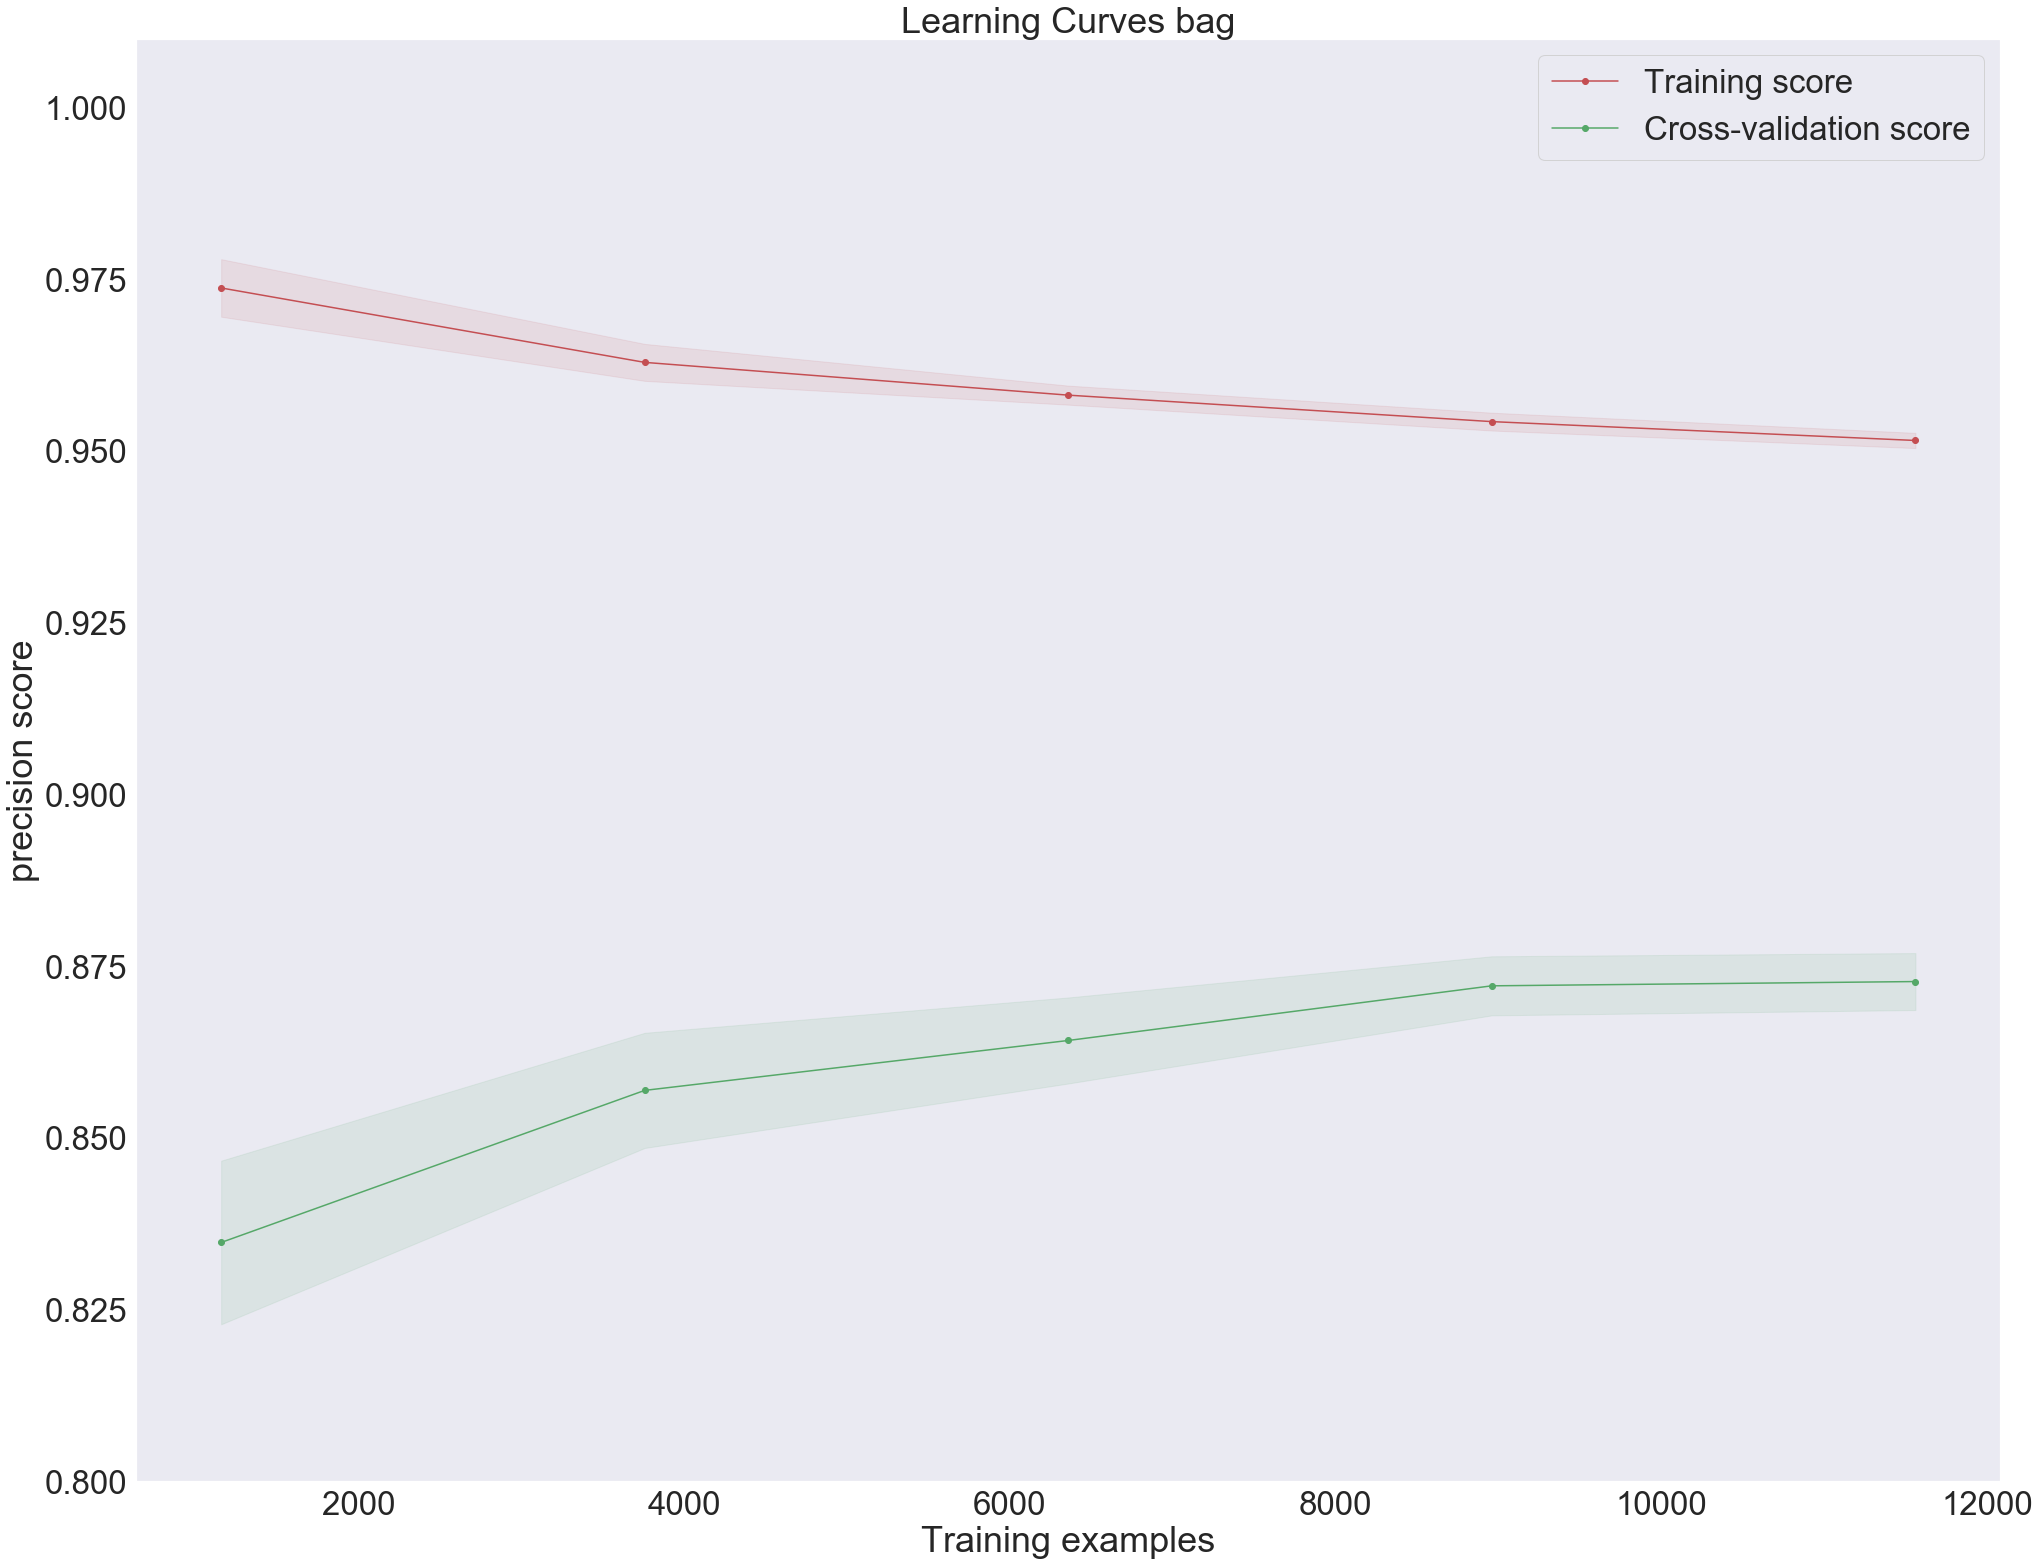

In [262]:
plot_learning_curve(estimator=top_model, title="Learning Curves {}".format(top_model_key),
                    X=X[all_x_vars],y=y, ylim=(0.8, 1.01), cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
                    , n_jobs=-1,scorer='precision')

##### Building a learning curver for the best performing model so far (again using precision as the performance metrics for reasons stated above), we can see that the training score starts very high (near 100%) and declines slightly to around 95% as more data samples are added, while the cross-validation set starts at around 85% and increases somewhat to around 87.5%. The high training score could be good in the sense that it suggests that the irreducible error for this problem may be quite small (e.g. it may be possible to build a high performing model), though at the same time it shows concerning signs of overfitting the problem as there is still a significant gap between the training an cross-validation performances as more training samples are added (meaning the model is unable to perform as well when given 'new' data as it was when predicting on data it had already seem - suggesting it is to some extent overfitting to that specific data). This is a common issue for high-variance models like this and steps will need to be taken going forward to reduce this issue.

In [266]:
def set_diag(self, values): 
    out = self
    n = min(len(out.index), len(out.columns))
    out.values[[np.arange(n)] * 2] = values
    
def negative_all_diag_confusion_matrix(cm):
    pd.DataFrame.set_diag = set_diag
    pd.DataFrame(cm).set_diag(-1)
    return cm

def plot_confusion_matrix(top_model,X_test_top, y_test_top,neg_out_diag = False,vmaxnorm = 1000,vmaxneg=100):
    sns.set(font_scale=3,rc={'figure.figsize':(33.4,26.54)})

    y_pred, y_test, acc = get_model_results(top_model,X_test_top, y_test_top)
    labels = target_definitions
    reversefactor = dict(zip(range(len(target_definitions)),target_definitions))
    y_test_v = np.vectorize(reversefactor.get)(y_test)
    y_pred_v = np.vectorize(reversefactor.get)(y_pred)
    ax = plt.subplot()
    cm = confusion_matrix(y_pred=y_pred_v, y_true=y_test_v,labels=labels)
    if neg_out_diag == True:
        cm = negative_all_diag_confusion_matrix(cm)
        sns.heatmap(cm, annot=True, ax = ax,fmt='g', cmap="Blues",vmin=1, vmax=vmaxneg)
    else:
        sns.heatmap(cm, annot=True, ax = ax,fmt='g', cmap="Blues",vmin=0, vmax=vmaxnorm) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix, model: ' + str(top_model_key))
    ax.yaxis.set_ticklabels(labels,rotation=0)
    ax.xaxis.set_ticklabels(labels,rotation=90)
    ax.plot()

##### As well as summary statistics, it is also very important to look at the raw confusion matrix for classification problems like this give an unaggregated sense of how the model is performing over each test example:

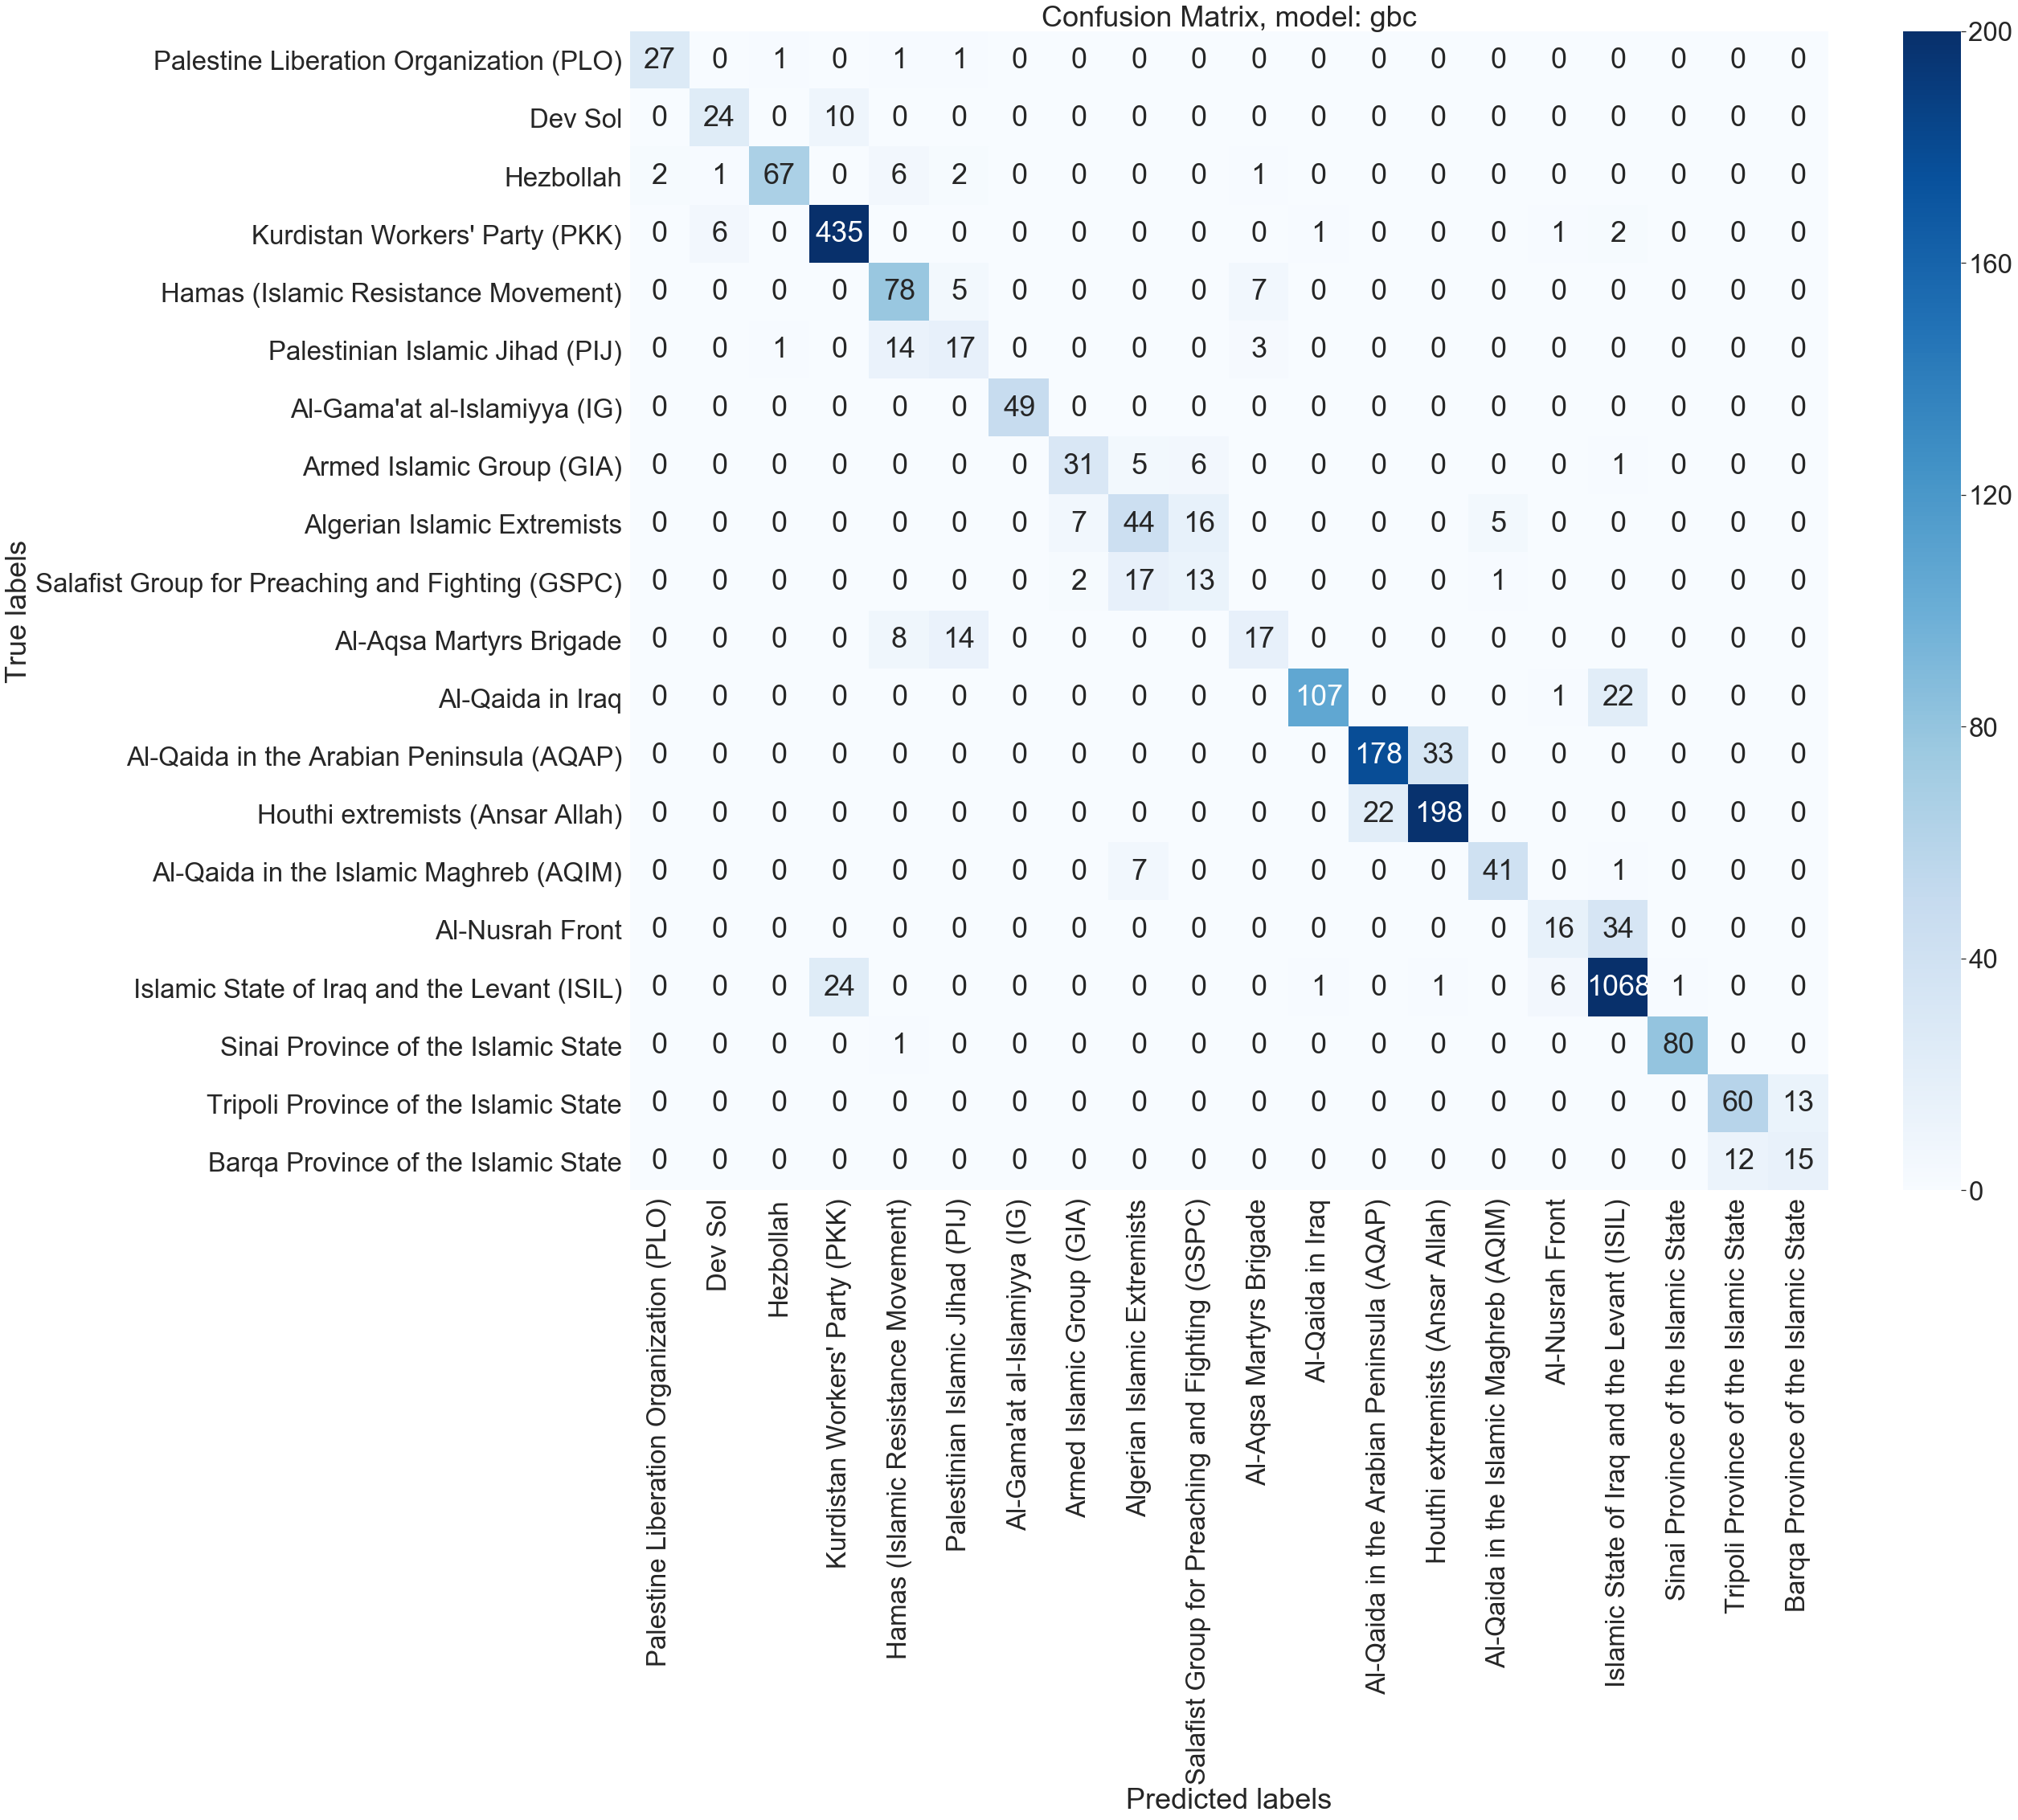

In [267]:
plot_confusion_matrix(top_model,X_test_top,y_test_top,vmaxnorm=200)

##### As we can see above the model is already performing well, with most the predictions matching the actual classes of the test set (i.e. the diagonal values). However it is worth replotting this matrix with the diagonals removed to emphasis the cases which the model got wrong (and which we should therefore focus on improving). This is plotted below:

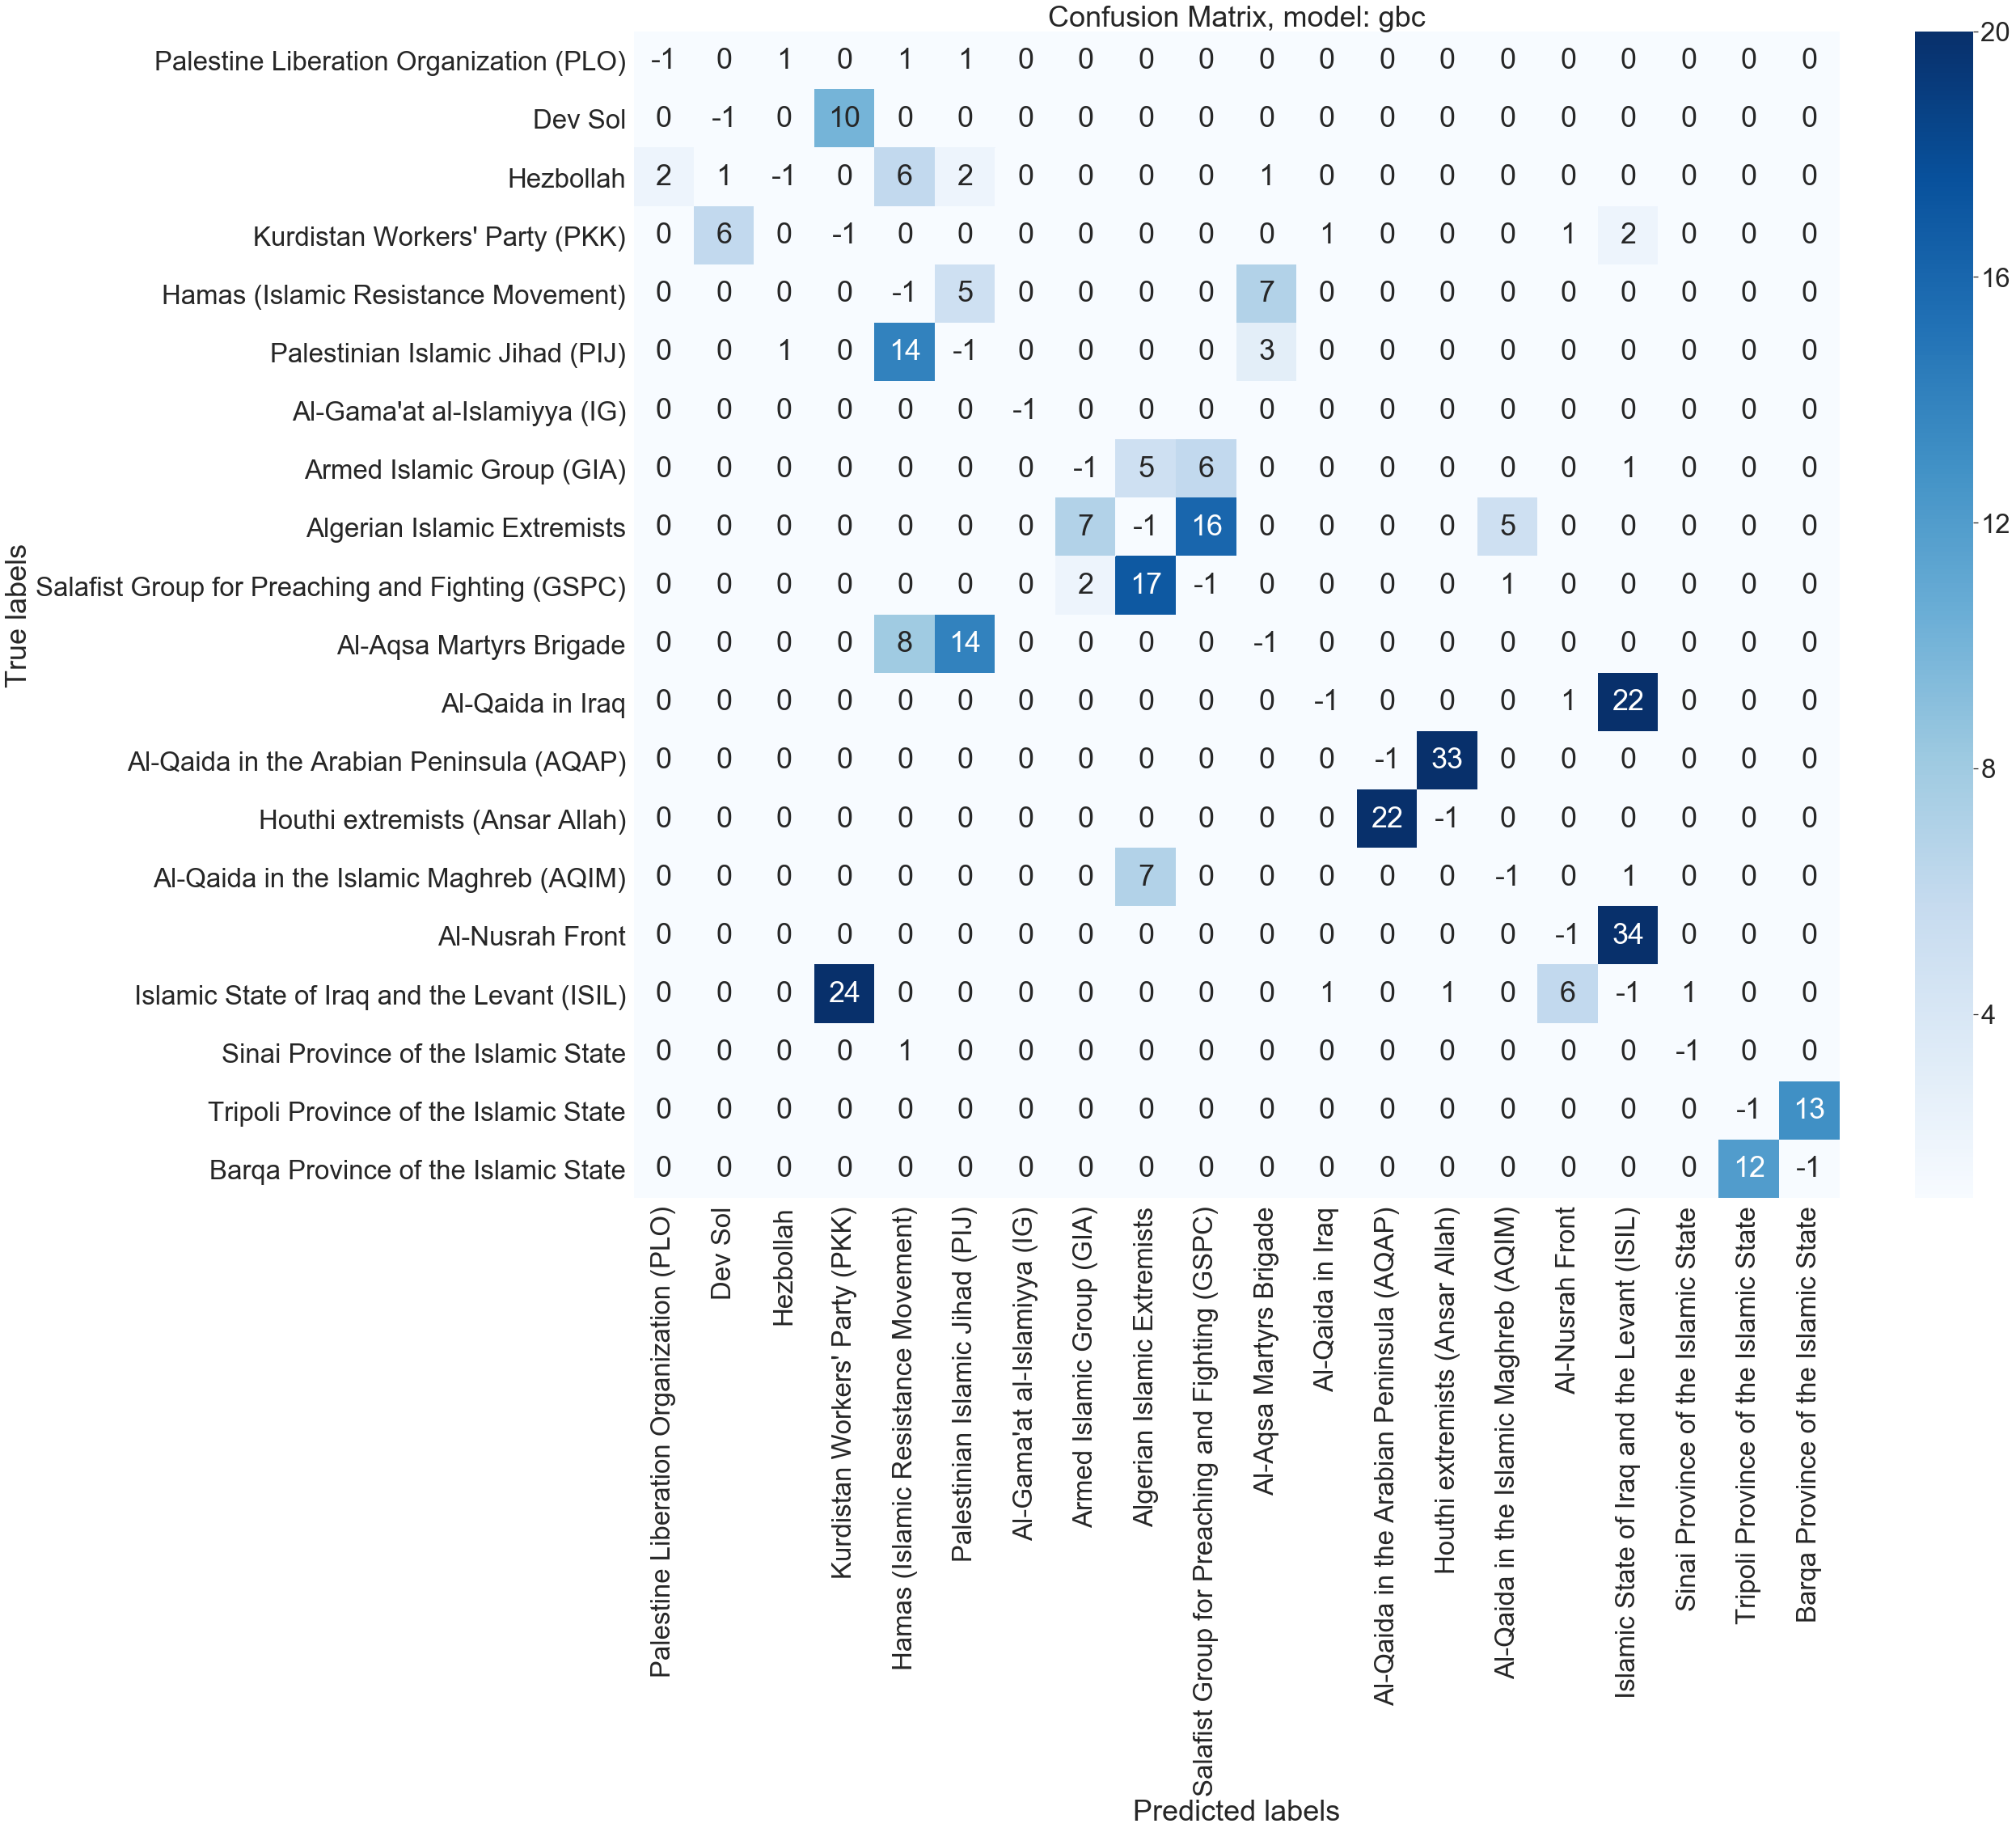

In [268]:
plot_confusion_matrix(top_model,X_test_top,y_test_top,neg_out_diag=True,vmaxneg=20)

##### We can see that even without any feature selection/cleaning/engineering, or model optimization we are already able to perform reasonable well to predict the top 20 known groups in the Middle East region using some standard (shallow learning) ensemble techniques. However looking at the confusion matrix above we can also see there is still lots of room for improvement with some classes having systematic False Negatives and False Positives. 

##### It is also worth assessing at this point the importance of the first 5 (uncleaned) explanitory variables used in the base line model. To do this we will use forest feature impotance as this is fairly robust to different data type and non-normalized features

In [201]:
def plot_feature_importance_boxplot(X,y,yrange=[-0.1,0.8]):
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=1)

    X_in = X[all_x_vars]
    forest.fit(X_in, y)
    importances = list(forest.feature_importances_)
    feature_names = all_x_vars

    df_trees = pd.DataFrame()
    for tree in forest.estimators_:
        importancetemp = tree.feature_importances_
        dftemp = pd.DataFrame(importancetemp)
        dftemp = dftemp.T
        df_trees = df_trees.append(dftemp)

    df_trees.columns = feature_names

    ordered_models = list(df_trees.mean().sort_values(ascending=False).reset_index()['index'])
    ordered_models.reverse()
    df_trees = df_trees[ordered_models]

    tracelist = []
    for col in df_trees.columns:
        x0 = list(df_trees[col])
        trace = go.Box(y=x0,name = col,boxpoints = False)
        tracelist.append(trace)
    data = tracelist
    layout = go.Layout(title='Spot check model performance',xaxis=dict(
        title='model'),
                       yaxis=dict(title=metric,range=yrange))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [42]:
# Build a forest and compute the feature importances
def plot_feature_importance2(X,y):
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=1)

    X_in = X[all_x_vars]
    forest.fit(X_in, y)
    importances = list(forest.feature_importances_)
    feature_names = all_x_vars
    
    name_dict = {}
    for index, digit in enumerate(importances):
        name = feature_names[index]
        name_dict[digit] = name
        
    importances.sort()
    feature_names =  list(map(lambda x:name_dict.get(x, None), importances))    
        
    plt.figure()
    plt.title("Feature importances")
    plt.bar(feature_names,importances, color="r", align="center")
    
    
    
    plt.xticks(range(len(importances)), feature_names,rotation=90)
    plt.show()

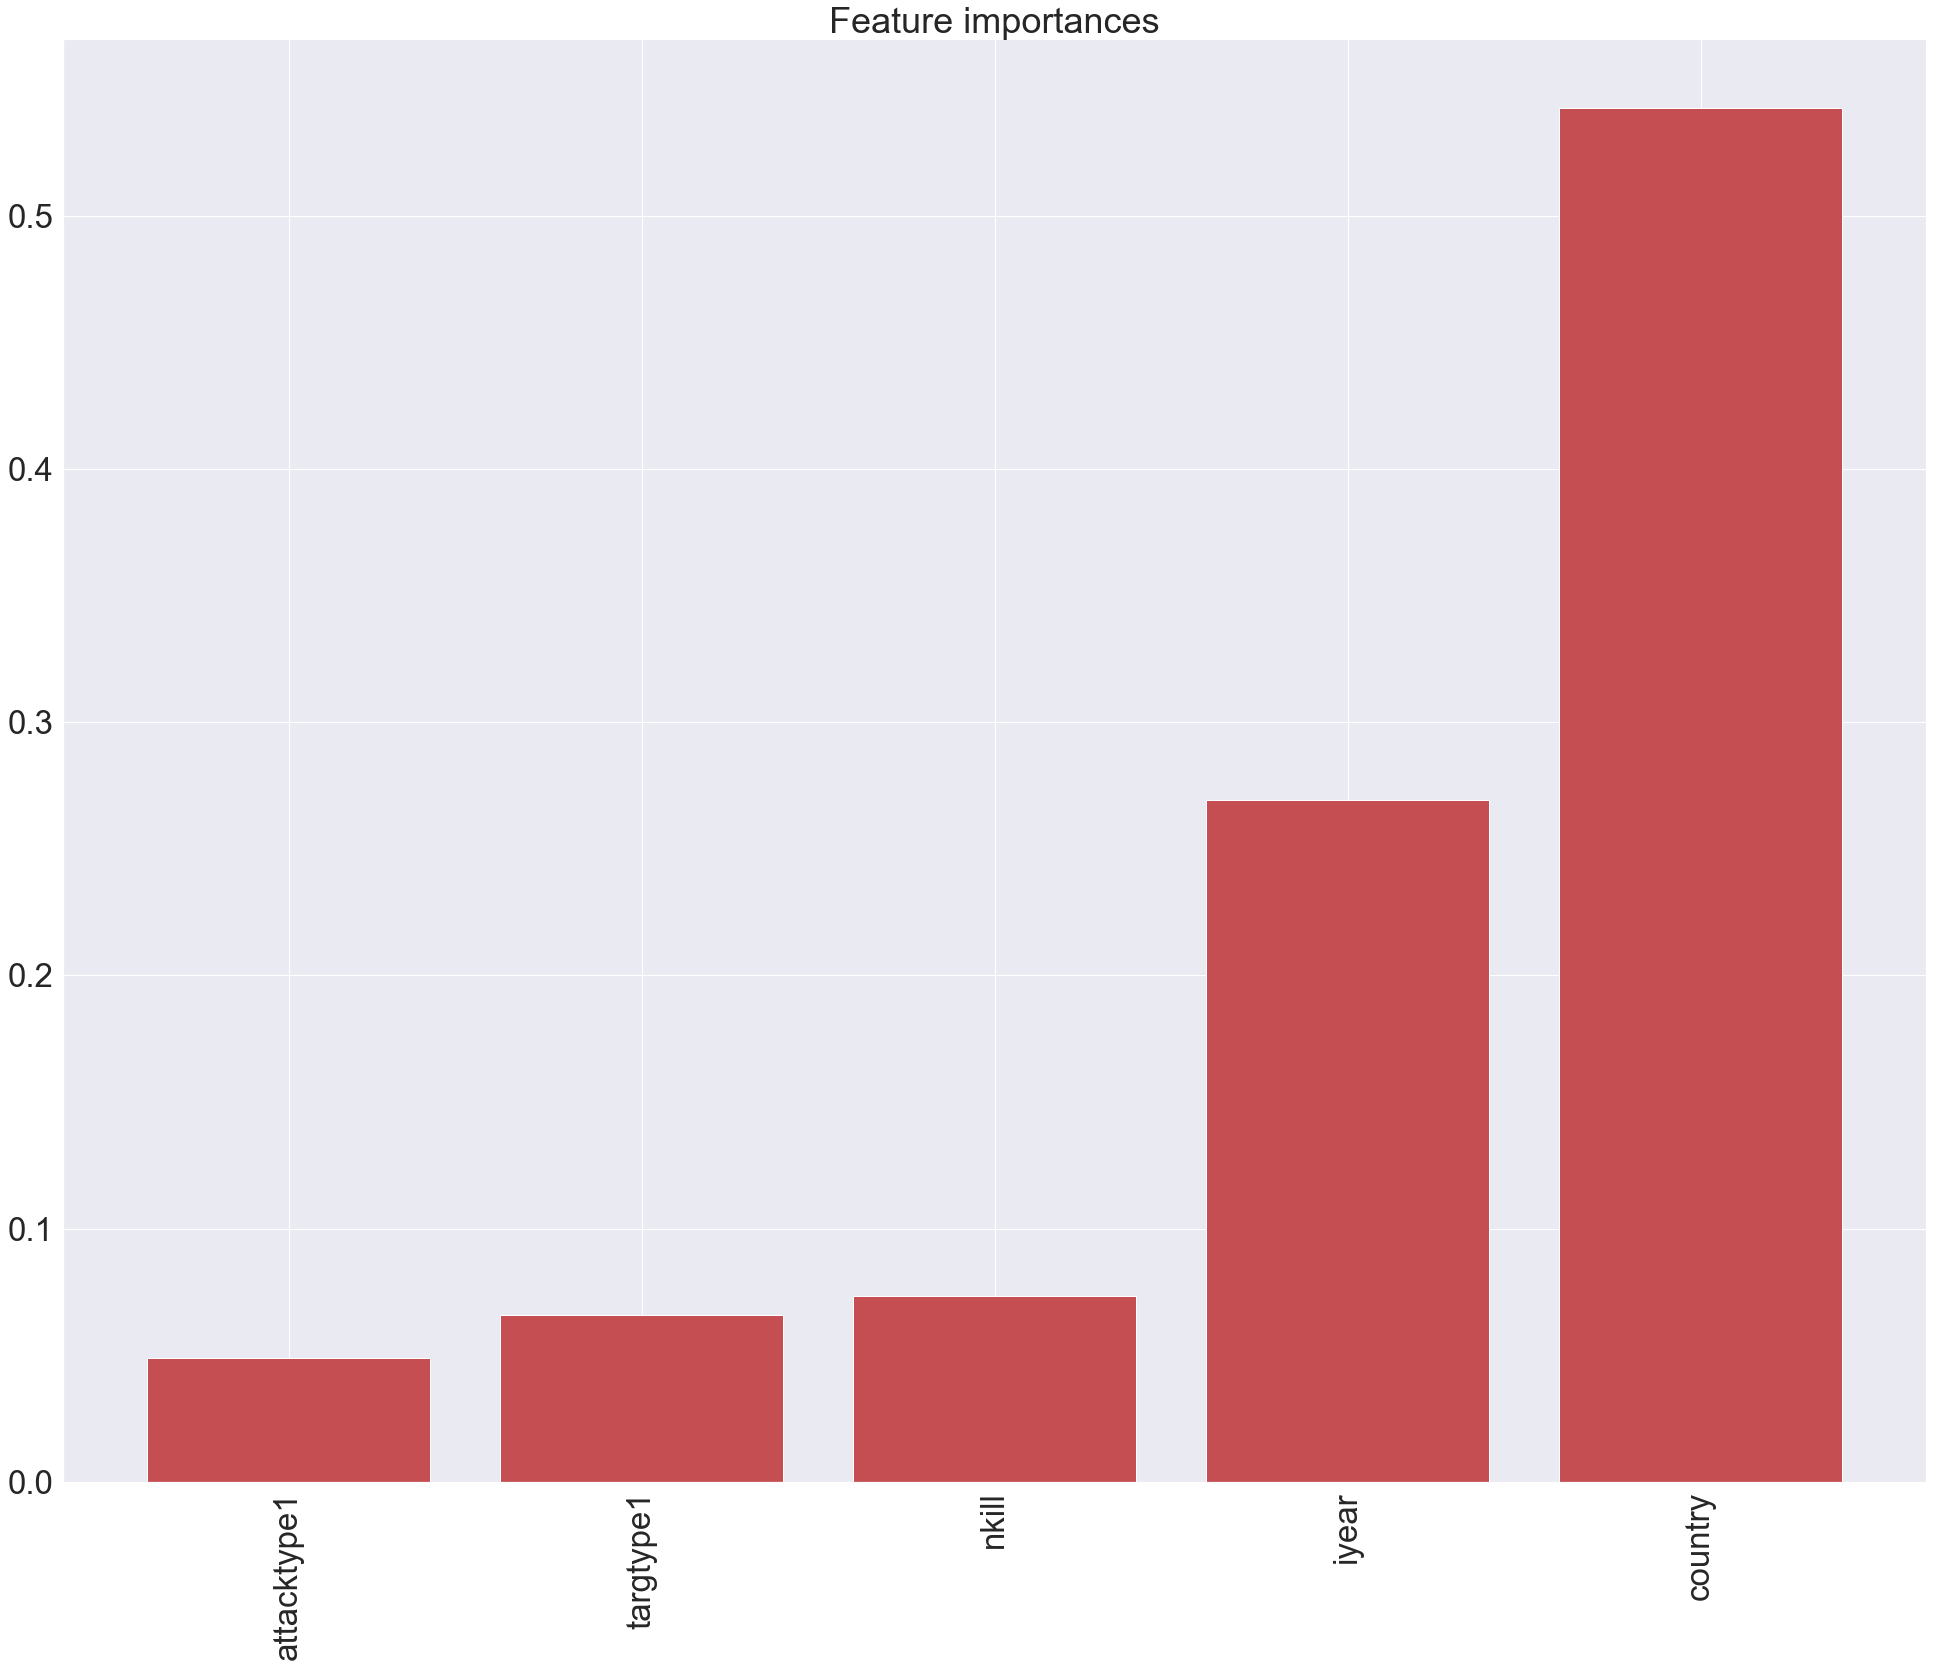

In [43]:
plot_feature_importance2(X,y)

In [202]:
plot_feature_importance_boxplot(X,y)

##### We can already see here that many of the features used (and especially country and year - as hypothesised ) were relevant for the model to some extend, with high explanitory power and a relitvley small standard deviation between decision trees suggesting they are robust features

# Modelling v2: Feature selection and cleaning

##### Now we have a baseline model to work from, lets spend some time going through the features that could be relevant, cleaning them where necessary and adding them to the model to evaluate if these could boost the predictive power, to do this I'll look at each feature in turn and create a new pipeline function to clean them as necessary:

##### Whilst a large number of fields were assessed (listed below) for this section, only a sample of fields are explored in more depth in order to demonstrate the process of evaluating whether to add a new field, as well as how they may need to be cleaned ready to feed to an improved model:

##### integer fields assessed and included
* 'nkill'
* 'nwound'
* 'nperps'
* 'nperpcap'
* 'nkillter'
##### ordinal fields assessed and included
* iyear
* imonth
* iday
##### categorical/binary fields assessed and included
* 'country'
* 'attacktype1'
* 'targtype1'
* 'ransom'
* 'natlty1'
* 'targsubtype1'
* 'suicide'
* 'provstate'
* 'claimmode'
* 'claimed'
* 'multiple'
* 'guncertain1'
* 'INT_LOG'
* 'INT_MISC'
* 'INT_ANY'
* 'city'
##### Other fields assessed but not included
* 'weapsubtype1' (not adding any new signal from weaptype)
* 'claimed' (not adding a lot to claimmode as always have claimmode if have claimed=1)
* 'individual' (basically always 0 so not useful)
* 'success' (mostly nulls seems to add no new signal)
* 'nkillus' (")
* 'nkillter' (")
* 'nwoundus' (") 
* 'nwoundte' (")
* 'extended' (")
* 'multiple' (")
* 'property' (")
* 'alternative' (")
* 'crit1' (")
* 'crit2' (")
* 'crit3' (")
* 'dbsource' (")
* INT HELPS (captured by other INT variables)
* INT_IDEO' (")



In [271]:
print("amount of NAs: ", round(1 - len(df[df['nperps'].notnull()]) / len(df),2), "%")
df[df['nperps'] < 1].groupby('nperps').count()['eventid'].reset_index()

amount of NAs:  0.39 %


nperps  eventid
0   -99.0    82218
1    -9.0        2
2     0.0      139

##### For example for 'nperps' we see there are a number of NA values which we will have to deal with to allow certain models to run (we can implace a dummy value for these). We also see a number of negative values which - given the field definition (e.g. number of perpertrators in the attack) does not make logic sense to be below 1. The reason for these negative values in that the original database uses these to code for Unknowns. However there are currently two differen negative values (-9, -99) for inexplicable reasons and thus, for data confirmity we will also recode these to our own dummy unknown values, along with zeros which - again - do not make logical sense for this field. It should also be noted that this field should of course be transformed to an integer as fits with its definition.

In [272]:
print("amount of NAs: ", round(1 - len(df[df['ransom'].notnull()]) / len(df),2), "%")
df['ransom'].unique()

amount of NAs:  0.57 %


array([ 0.,  1., nan, -9.])

##### 'ransom' should be transformed to a categorical/binary variable (denoting whether or not a random was demanded as part of the attack). Again there are many NAs which makes sense as if a hostage was not taken - which is not always the case - then a ransom cannot be demanded. These can be dropped or recoded as necessary. However looking at the unique values of this field we again see a negative value which needs to be recoded to conform with our own dummy unknown values.

##### Now that new fields have been identified and the cleaning steps needed for them understood, a new pipeline can be built which can systematically deal with this cleaning and preperation in order to feed them into a new (V2) model

In [273]:
def main_pipeline_features(df,region='Middle East & North Africa',generic_groups = [], 
                           nclasses=0,msample=0,msample_random_state=1,
                          x_vars_int = [],x_vars_float = [], x_vars_ordered= [],x_vars_cat = [],
                           x_id=['eventid'],y_var='gname',
                           return_unknowns=False,upsample=False):
    
    # look at just one region
    dfreg = df[df['region_txt'] == region]

    # split into known and unknowns
    dfreg_known = dfreg[dfreg['gname'] != 'Unknown']
    dfreg_unknown = dfreg[dfreg['gname'] == 'Unknown']
    
    # remove general groups
    dfreg_known = dfreg_known[~dfreg_known['gname'].isin(generic_groups)]
    
    # cut down to N groups if nclasses specified 
    if nclasses == 0:
        nclasses = len(df_gname_group_known['gname'].unique())

    # switch to return unknowns with same cleaning for deployment phase 
    if return_unknowns == True:
        dfreg_kn = dfreg_unknown
    else:
        dfreg_kn = dfreg_known
    
    top_n_groups = set(list(dfreg_kn.groupby('gname').count()['eventid'].reset_index().sort_values('eventid',ascending=False).head(nclasses)['gname']))
    df_top_n_groups = dfreg_kn[dfreg_kn['gname'].isin(top_n_groups)]

    # sample down to M records if sample size specified 
    if msample == 0:
        msample = len(df_top_n_groups)
    df_top_n_small = df_top_n_groups.sample(msample,random_state=msample_random_state)
    df_sample = df_top_n_small
    
    # more advanced fields cleaning to change NAs to an arbitary code value etc. 
    fields_to_fill_na_with_code = ['nkill','nwound','nperps','nperpcap','ransom','natlty1',
                                   'targsubtype1','claimmode','weapsubtype1','claimed','alternative',
                                   'nkillus','nkillter','nwoundus','nwoundte','weaptype1','multiple','guncertain1',
                                  'ishostkid','latitude','longitude']
    for field in fields_to_fill_na_with_code:
        df_sample = pipeline_cleaning_fillna_int(df_sample,field=field,fill_value=-99)
    
    df_sample['nperps'] = df_sample['nperps'].replace(to_replace=0,value=-99)
    df_sample['ransom'] = df_sample['ransom'].replace(to_replace=-9,value=-99)
    df_sample['claimed'] = df_sample['claimed'].replace(to_replace=-9,value=-99)    
    df_sample['property'] = df_sample['property'].replace(to_replace=-9,value=-99)
    df_sample['ishostkid'] = df_sample['ishostkid'].replace(to_replace=-9,value=-99)

        
    df_sample['success'] = df_sample['success'].astype('bool')
    df_sample['suicide'] = df_sample['suicide'].astype('bool')
    df_sample['extended'] = df_sample['extended'].astype('bool')
    df_sample['multiple'] = df_sample['multiple'].astype('bool')
    df_sample['individual'] = df_sample['individual'].astype('bool')


    df_sample['provstate'] = df_sample['provstate'].astype('category').cat.codes
    df_sample['city'] = df_sample['city'].astype('category').cat.codes
    df_sample['dbsource'] =  df_sample['dbsource'].astype('category').cat.codes
    
    #convert to proper datatypes 
    df_sample = pipeline_cleaning_convert_to_proper_datatypes(df_sample,x_vars_int, x_vars_float, x_vars_ordered, x_vars_cat,y_var)
    
    #factorize target variable and get codes/definitions 
    df_sample, target_definitions = pipeline_cleaning_factorize_target(df_sample,y_var)

    # return cleaned dataframe
    df_sample_clean = df_sample[all_vars].reset_index()
    
    # switch to upsample data to balanced classes
    if upsample == True:
        print("original data size before upsampling:", len(df_sample_clean))
        df_ust = df_sample_clean
        df_nsamples = df_ust.groupby('gname').count().reset_index().sort_values('eventid',ascending=False)
        max_samples = df_nsamples['eventid'].max()
        df_largest_group_name = df_nsamples['gname'].iloc[0]
        df_largest_group = df_ust[df_ust['gname'] == df_largest_group_name]
        df_upsampled = df_largest_group 
        for i in list(df_ust['gname'].unique()[1:]):
            df_other_group_name = df_nsamples['gname'].iloc[i]
            df_other_group =df_ust[df_ust['gname'] == df_other_group_name]

            df_minority_upsampled = resample(df_other_group,replace=True,     # sample with replacement
                                             n_samples=max_samples,    # to match majority class
                                             random_state=1)

            df_upsampled = pd.concat([df_upsampled , df_minority_upsampled])
        df_sample_clean = df_upsampled
    
    # print checks
    print("clean dataframe created: ", "shape - ", df_sample_clean.shape, "number of NAs - ", len(df_sample_clean[pd.isnull(df_sample_clean).any(axis=1)]))
    return df_sample_clean, target_definitions



##### It is also worth reinitializing our model dictonary to compare just the most promising models in order to save time

In [483]:
def create_models_dict_v2(models = {}):
    #models['lor'] = (LogisticRegression(),[{}])
    models['knn'] = (KNeighborsClassifier(),[{}])
    #models['svc'] = (SVC(),[{}]) # Slow
    #models['gnb'] = (GaussianNB(),[{}])
    models['dtc'] = (DecisionTreeClassifier(),[{}])
    models['etc'] = (ExtraTreeClassifier(),[{}])
    #models['ada'] = (AdaBoostClassifier(),[{}])
    models['rfc'] = (RandomForestClassifier(),[{}])
    models['bag'] = (BaggingClassifier(),[{}])
    models['gbc'] = (GradientBoostingClassifier(),[{}]) # Slow
    return models

##### Finally it is worth noting that, inaddition to the new features added, this pipeline also allows us to upsample the data in order to balance class distribution. Whilst this is not necessary for all model types (e.g random forest / bag models can cope with unbalanced classes regardless), it may be important for other models under consideration.

### Run models (v2)

In [484]:
### Inputs 
region = 'Middle East & North Africa'
generic_groups = ['Muslim extremists','Palestinian Extremists','Palestinians','Islamist extremists', 'Tribesmen','Separatists', 'Gunmen']

x_id = ['eventid']
x_vars_int = ['nkill','nwound','nperps','nperpcap','nkillter']
x_vars_ordered= ['iyear','imonth','iday']
x_vars_cat = ['country','attacktype1','targtype1','ransom','natlty1','targsubtype1','suicide','provstate',
             'claimmode','claimed','multiple','guncertain1','INT_LOG','INT_MISC','INT_ANY','city']
y_var = 'gname'
all_x_vars =  x_vars_int + x_vars_ordered + x_vars_cat  
all_vars = x_id + all_x_vars + [y_var]

nclasses = 20

metric = 'precision'  # acc / f1 / precision / recall / f1

df_sample_clean, target_definitions = main_pipeline_features(df,region=region,generic_groups=generic_groups,
                                                                        nclasses=nclasses,
                                                                        msample_random_state=1,
                                                                        x_vars_int = x_vars_int,
                                                                        x_vars_ordered= x_vars_ordered,
                                                                        x_vars_cat = x_vars_cat,x_id=x_id,
                                                                        y_var=y_var,upsample=False)


X, y, folded_data_dict = split_kfold_cv_train_test(df_sample_clean=df_sample_clean,y_var=y_var,
                                             x_id=x_id,all_x_vars=all_x_vars,n_splits=10,test_size=0.2,kfold_cv_random_state=1)

base_models = create_models_dict_v2()

results, top_model_key, top_model, X_train_top, y_train_top, X_test_top, y_test_top, y_pred_top, test_id_top = spot_check_models(models=base_models,folded_data_dict=folded_data_dict,metric=metric)

plot_models_acc(results,metric)

clean dataframe created:  shape -  (14452, 27) number of NAs -  0
model:  knn metric, precision:  0.806 time:  27.568299531936646
model:  dtc metric, precision:  0.94 time:  1.954789161682129
model:  etc metric, precision:  0.849 time:  1.380309820175171
model:  rfc metric, precision:  0.939 time:  4.132951736450195
model:  bag metric, precision:  0.948 time:  8.901235103607178


In [489]:
results_v2 = results
top_model_v2 = top_model

##### Comparing v1 (minimal features) with v2 (many cleaned/transformed features), we can see the performance is significantly better for most models (though for some models this comes at the expense of greatly increased run-times)

In [468]:
try:
    results_v1.columns = [x + '_v1' for x in results_v1.columns if 'v1' not in x]
except:
    pass

try:
    results_v2.columns = [x + '_v2' for x in results_v2.columns if 'v2' not in x]
except:
    pass

results_compare = results_v1[['gbc_v1','bag_v1']]
results_compare['gbc_v2'] = results_v2['gbc_v2']
results_compare['bag_v2'] = results_v2['bag_v2']
plot_models_acc(results_compare,metric)

##### and looking at the confusion matrix for the best performing model we can see a systematic improvement too 

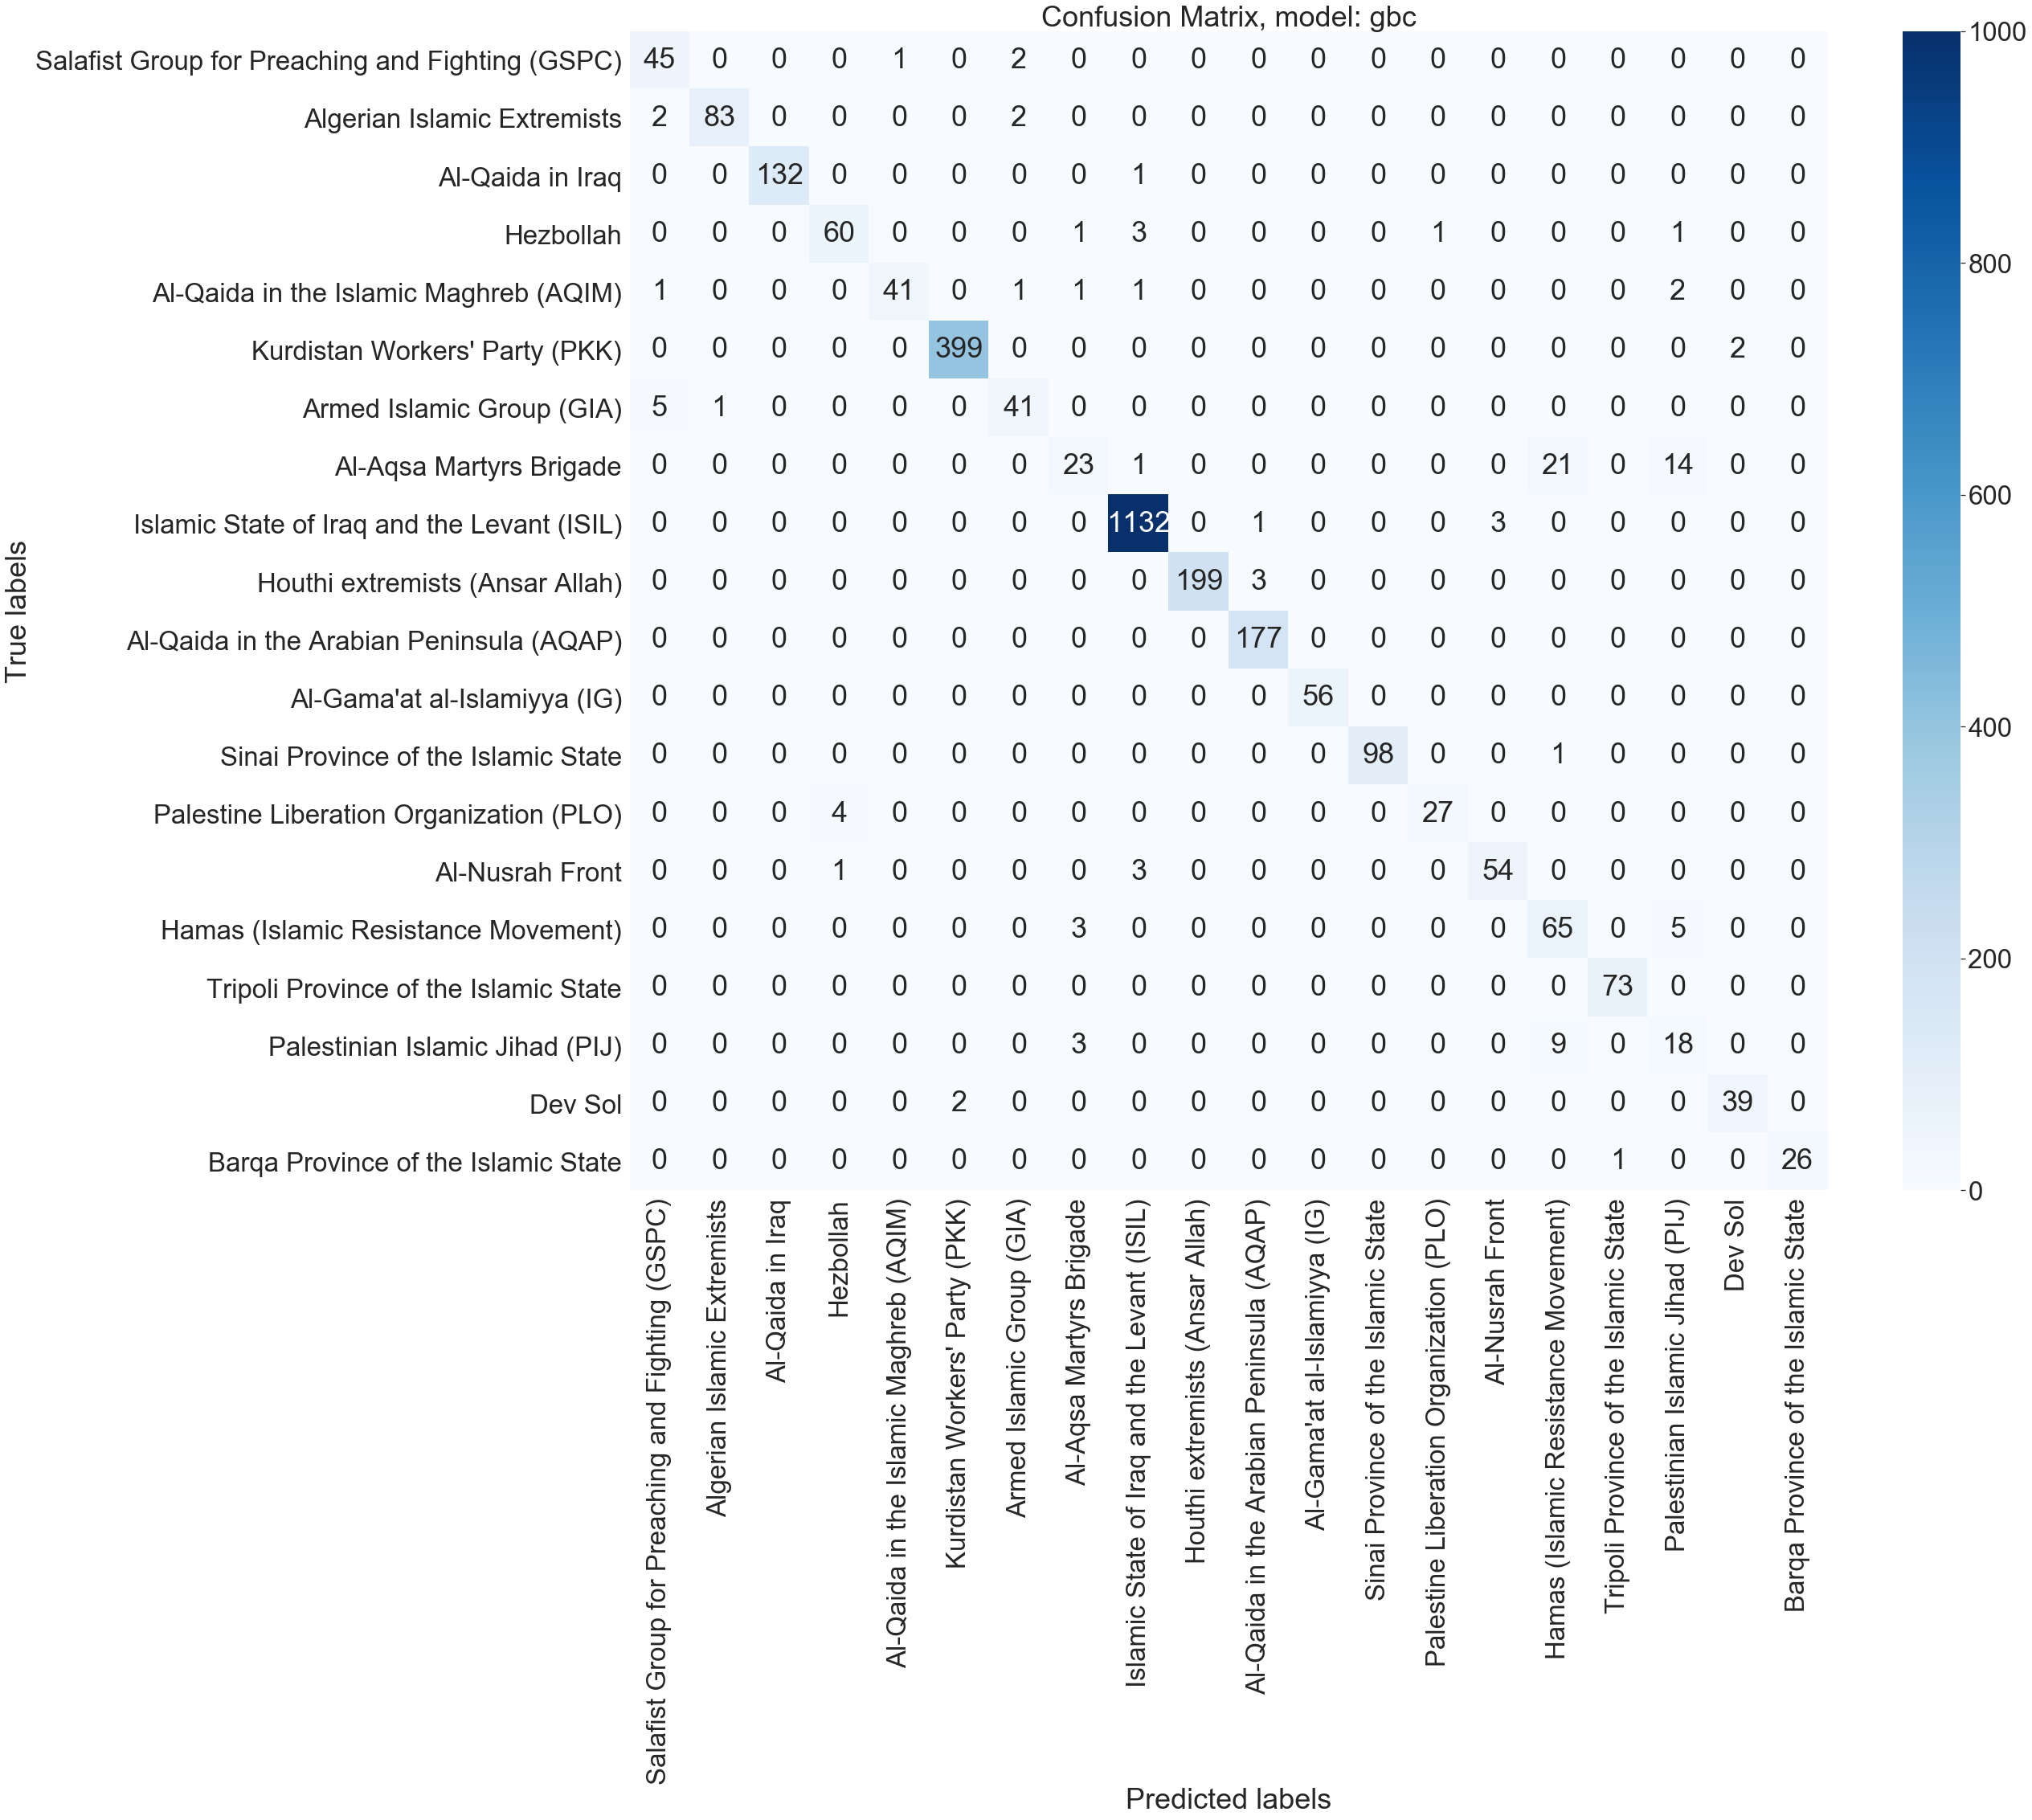

In [327]:
plot_confusion_matrix(top_model,X_test_top,y_test_top)

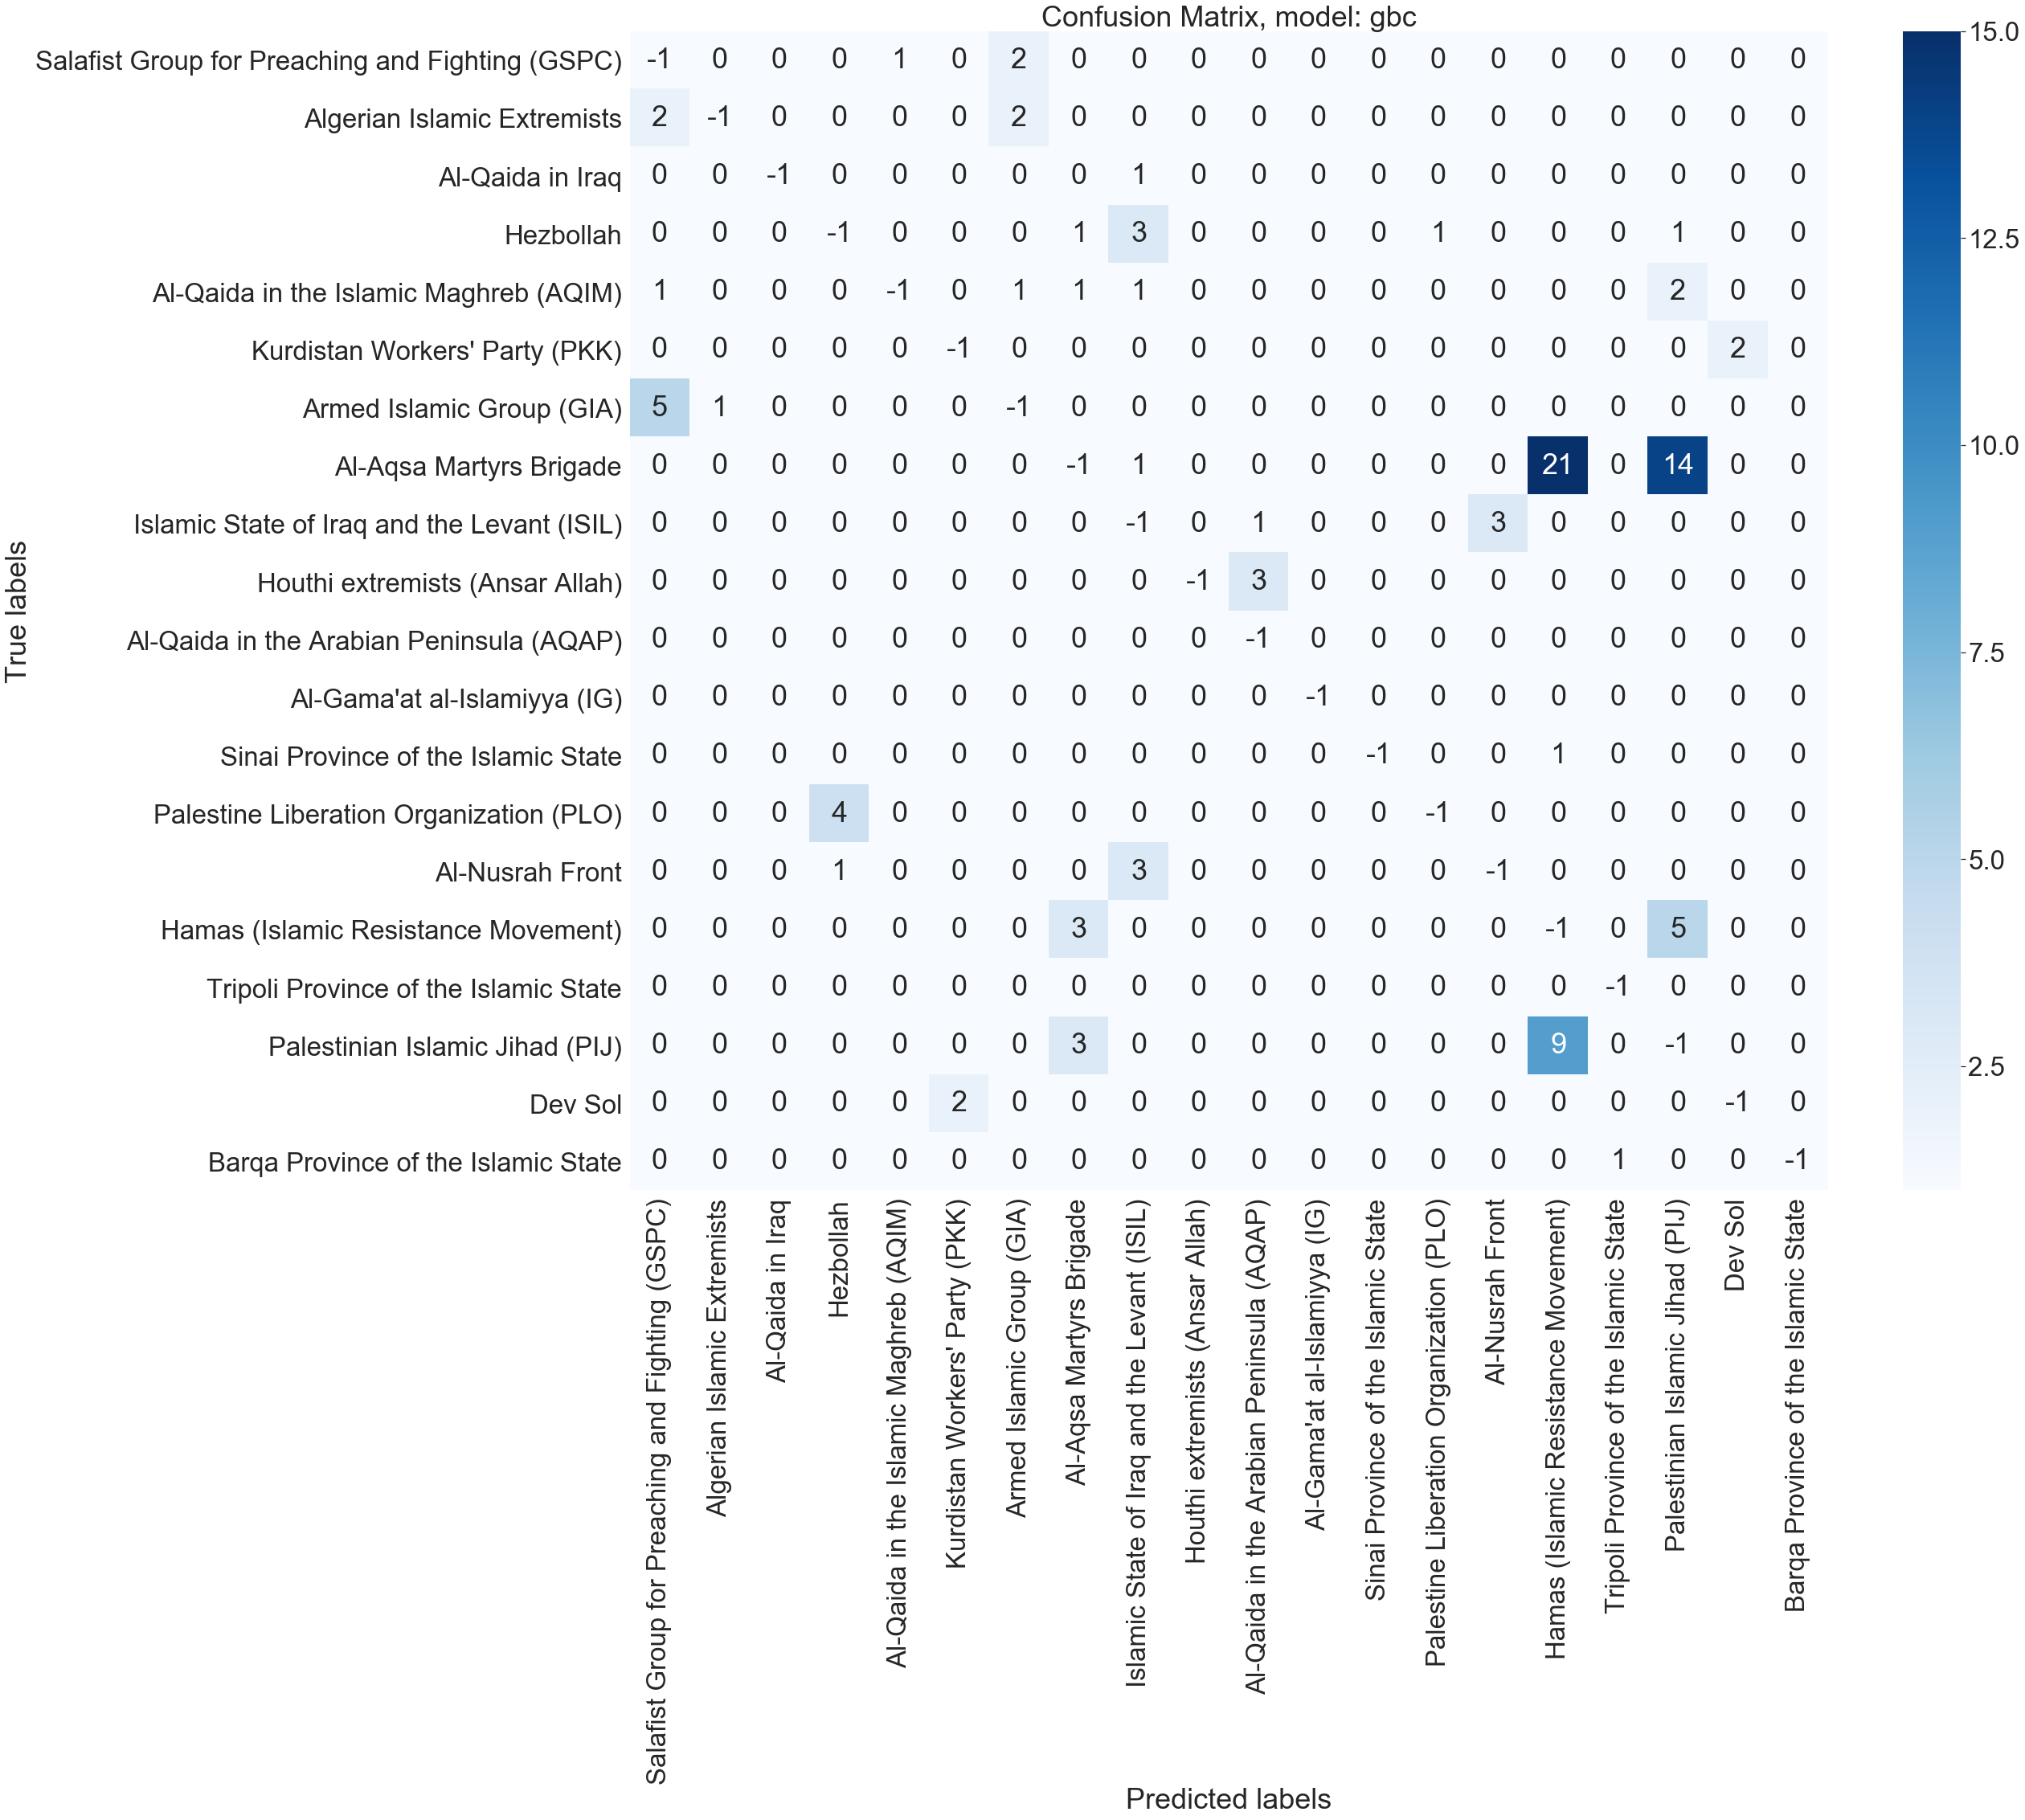

In [330]:
plot_confusion_matrix(top_model,X_test_top,y_test_top,neg_out_diag=True,vmaxneg=15)

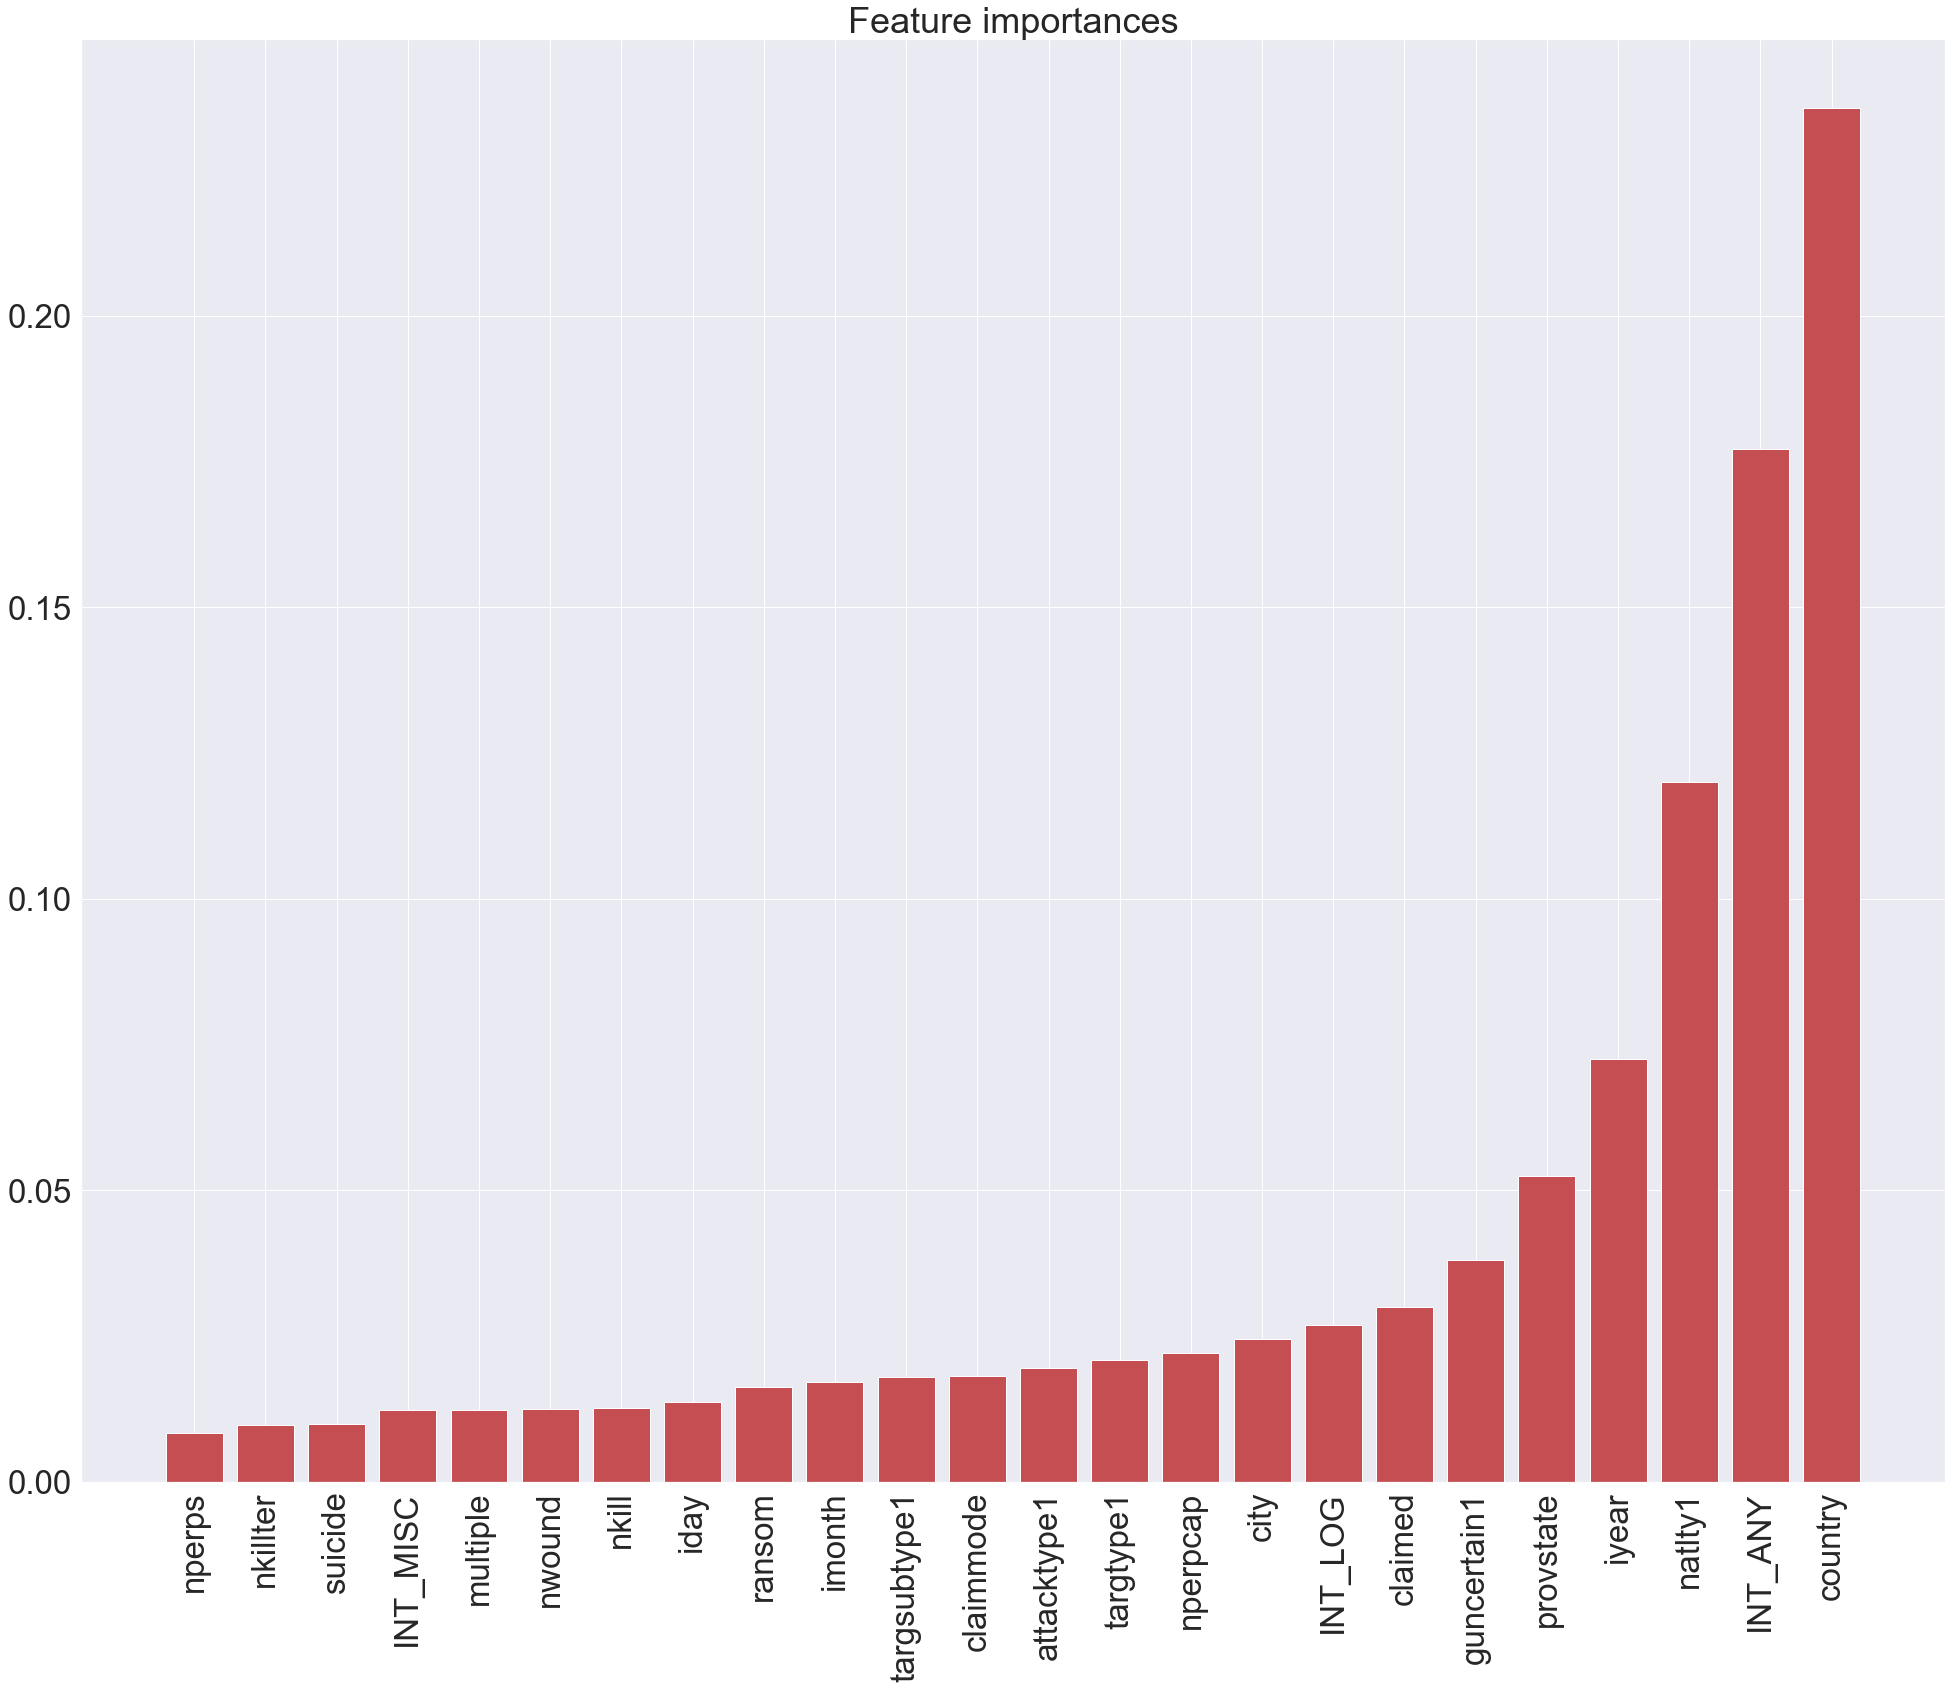

In [331]:
plot_feature_importance2(X[all_x_vars],y)

In [334]:
plot_feature_importance_boxplot(X[all_x_vars],y,yrange=[-0.1,0.45])

# Modelling v3: NLP feature engineering

##### another route we could take to improve our model is feature engineering, whilst there are many options here, there are quite a few text fields which may be transformed using NLP techniques into fields that could be used to further the models prediction power. To do this we will first need to build a series of functions to transform the raw text data into cleaned field vectors:

In [353]:
def tokenize_and_clean_text(df, text_field_in='text_field_in',token_field_out='tokenized_description',remove_words=[],stem=True):
    df[token_field_out] = df[text_field_in].astype(str) 
    if len(remove_words) > 0:
        for word in remove_words:
            df[token_field_out] = df[token_field_out].str.replace(word,'')
    df[token_field_out] = df[token_field_out].str.replace('[^\w\s]', '')  # REMOVE ALL PUNCTUATION
    df[token_field_out] = df[token_field_out].str.lower()  # LOWER CASE EVERYTHING
    df[token_field_out] = df[token_field_out].str.replace('nan', '')  # REMOVE NANS
    df[token_field_out] = df[token_field_out].str.split(' ')  # TOKENIZE DESCRIPTIONS
    stop_words = list(set(stopwords.words('english')))  # REMOVE STOP WORDS 
    df[token_field_out] = df[token_field_out].apply(lambda x: [item for item in x if item not in stop_words])
    if stem == True:
        stemmer = SnowballStemmer("english")
        df[token_field_out] = df[token_field_out].apply(lambda x: [stemmer.stem(word) for word in x]) # STEMM WORDS ()
    return df

In [373]:
def count_words(df, col):
    words = str(list(df[col])).split(' ')
    words = [x.lower().replace('"','').replace("'",'').replace("[","").replace("]","").replace('.','').replace(',','') for x in words]

    return Counter(words).most_common()  

In [374]:
def word_vec(df_sample,text_col_in,topn=10,remove_words = [],stem=True):
    text_col_out = text_col_in + "_clean"
    df_sample = tokenize_and_clean_text(df_sample,text_field_in=text_col_in,token_field_out=text_col_out,remove_words=remove_words,stem=stem)
    field_list = [x[0] for x in count_words(df_sample, text_col_out)[0:topn]]
    for tar in field_list:
        df_sample[tar] = df_sample[text_col_out].astype(str).str.lower().str.contains(tar)
    return df_sample, field_list

##### We can then take the top n words from text fields such as 'target1', 'wepdetail', and 'motive' - cleaning them along the way with numerous NLP pre-processing techniques such as removing punctuation, lower casing, tokenization, removing stops words, and stemming the words (using the snowball stemmer algorithm in this case) to clean the words to combine similar words (e.g. civilian and civilians) and keeping only those likely to contain signal:

In [382]:
#df_feng, tar_list = word_vec(df,'target1',topn=50)
#df_feng, wep_list = word_vec(df,'weapdetail',topn=50)
df_feng, mot_list = word_vec(df,'motive',topn=100,
                             remove_words=['however','motive','specific','source','suspect','unknown','','note',
                                          "attack"],stem=False)

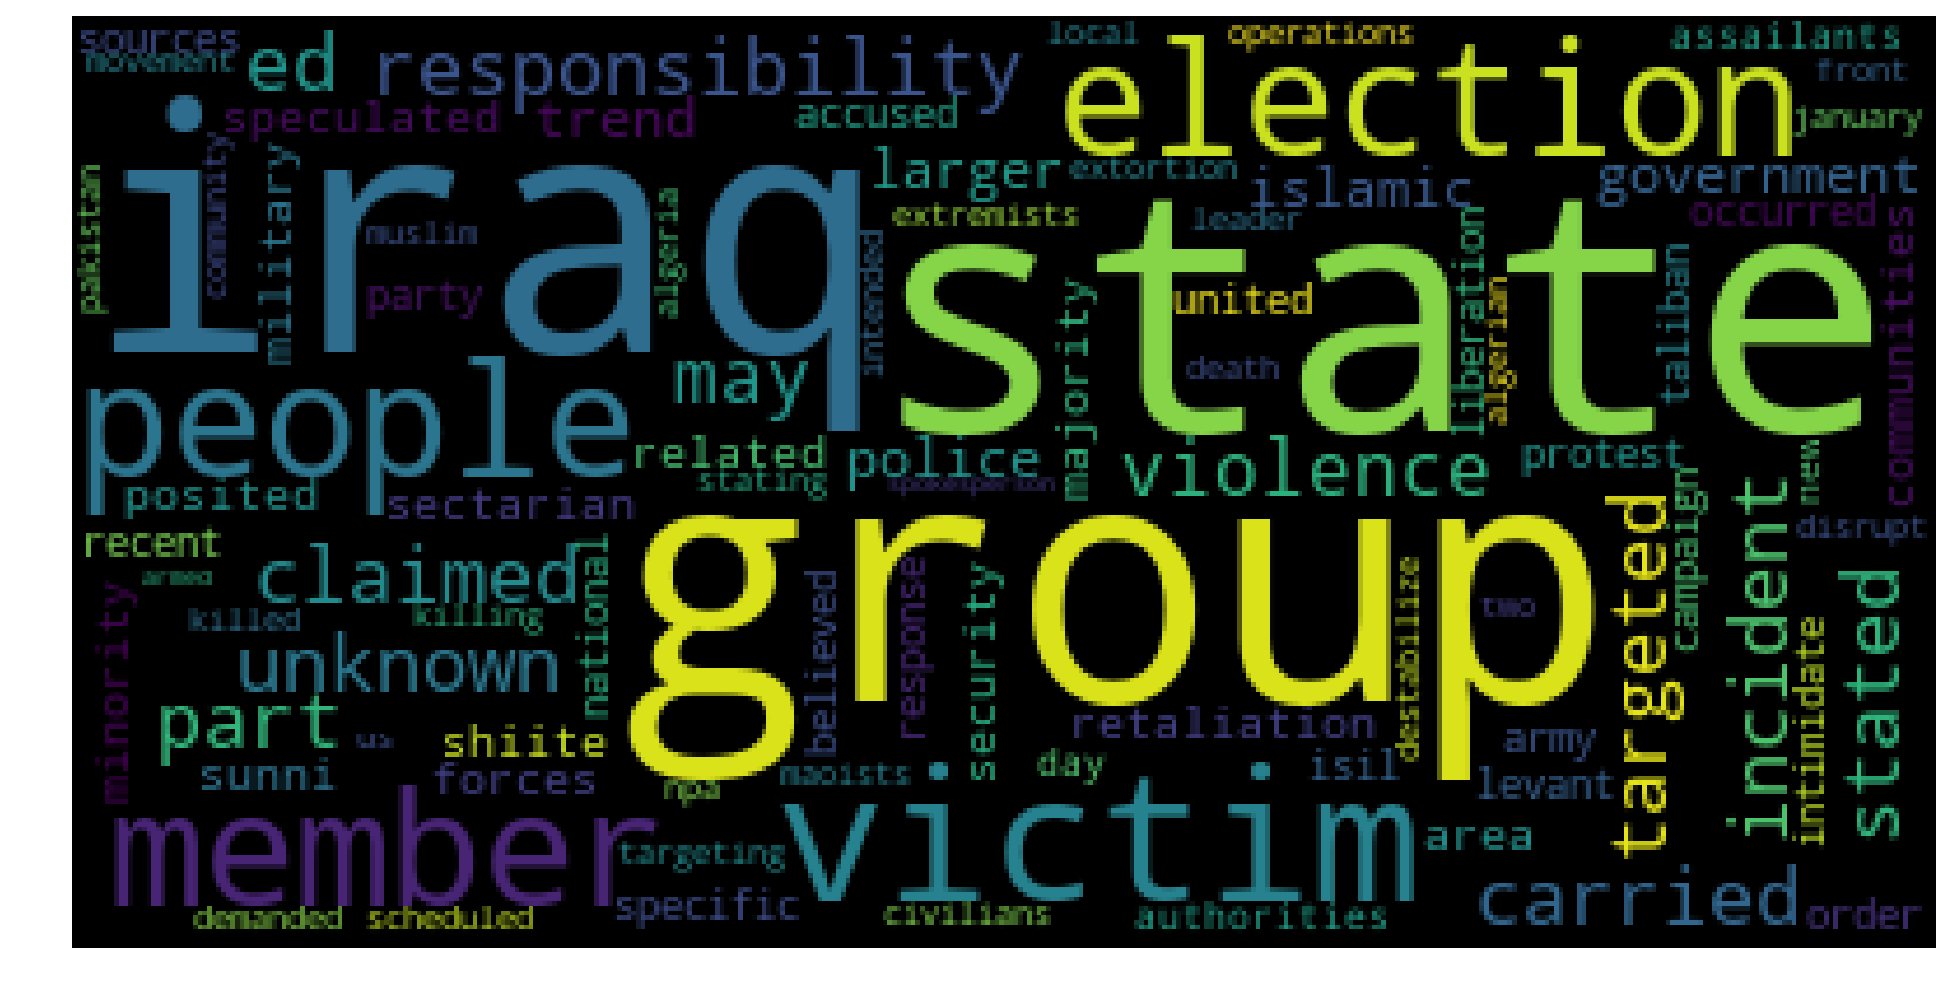

In [383]:
# wordcloud to vizualize the type of word vectors 
text = str(mot_list).replace('"','').replace("'",'').replace("[","").replace("]","").replace('.','').replace(',','')
wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = set(STOPWORDS)
                      ).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Run model (v3)

In [386]:
def create_models_dict_v3(models = {}):
    models['bag'] = (BaggingClassifier(),[{}])
    models['gbc'] = (GradientBoostingClassifier(),[{}]) # Slow
    return models

In [390]:
### Inputs 
region = 'Middle East & North Africa'
generic_groups = ['Muslim extremists','Palestinian Extremists','Palestinians','Islamist extremists', 'Tribesmen','Separatists', 'Gunmen']

x_id = ['eventid']
x_vars_int = ['nkill','nwound','nperps','nperpcap','nkillter']
x_vars_ordered= ['iyear','imonth','iday']
x_vars_cat = ['country','attacktype1','targtype1','ransom','natlty1','targsubtype1','suicide','provstate',
             'claimmode','claimed','multiple','guncertain1','INT_LOG','INT_MISC','INT_ANY','city'] + mot_list 
y_var = 'gname'
all_x_vars =  x_vars_int + x_vars_ordered + x_vars_cat  
all_vars = x_id + all_x_vars + [y_var]

nclasses = 20

metric = 'precision'  # acc / f1 / precision / recall / f1

df_sample_clean, target_definitions = main_pipeline_features(df_feng,region=region,generic_groups=generic_groups,
                                                                        nclasses=nclasses,
                                                                        msample_random_state=1,
                                                                        x_vars_int = x_vars_int,
                                                                        x_vars_ordered= x_vars_ordered,
                                                                        x_vars_cat = x_vars_cat,x_id=x_id,
                                                                        y_var=y_var,upsample=False)


X, y, folded_data_dict = split_kfold_cv_train_test(df_sample_clean=df_sample_clean,y_var=y_var,
                                             x_id=x_id,all_x_vars=all_x_vars,n_splits=10,test_size=0.2,kfold_cv_random_state=1)

base_models = create_models_dict_v3()

results, top_model_key, top_model, X_train_top, y_train_top, X_test_top, y_test_top, y_pred_top, test_id_top = spot_check_models(models=base_models,folded_data_dict=folded_data_dict,metric=metric)

plot_models_acc(results,metric)

clean dataframe created:  shape -  (14452, 127) number of NAs -  0
model:  bag metric, precision:  0.949 time:  23.68567681312561


In [391]:
#results_v3 = results 

In [392]:
try:
    results_v3.columns = [x + '_v3' for x in results_v3.columns if 'v3' not in x]
except:
    pass
results_compare2 = results_v2[['gbc_v2','bag_v2']]
results_compare2['gbc_v3'] = results_v3['gbc_v3']
results_compare2['bag_v3'] = results_v3['bag_v3']
plot_models_acc(results_compare2,metric)

##### Unfortunatley NLP word features does not seem to affect model performance in any statistically significant way, suggesting it adds no real signal to the final model. Moreover such a large vector space of fields increases the model run-time dramatically. For this reason this features will not be included in the final model, though through more feature engineering it may be possible to make these more useful in the future.

In [389]:
#top_model_gbc = top_model

# Modelling v4: final selection and parameter tuning 

##### While GBC was able to marginally outperform Bagging in performance, the order of magnitude run-time difference between them suggest Bagging to be the best overall model (of those test) for final selection in this analysis.

### Creating a development and evaluation set 

##### For the final iteration of the modellin step, parameter tuning of the models will be focused on to see if adjusting hyperparameters of the models can help improve performance

##### However when tuning model parameters it is important to remember that we are, to some extent, 'overfitting' the tuned model to the training/test set as these optimized parameters may only be optimized for this data sample. To help avoid this and to evaluate the final model properly we will therefore first remove a portion of the dataset to act as an 'evaluation set' (i.e. a portion of the data that is never seem by the model either in training or tuning) which can be used to assess how well the final model has generalized. 

##### While splitting out a training/testing/evaluation set is good practice and will be done explicitly in this analysis, it is worth noting that, because our final model selections are using an ensemble method based upon bagging then part of the training set remains unused in each iteration. This left out portion should in itself help guard against overfitting and help create a more generalized model without having to rely on a validation set.

In [427]:
percentage_for_evaluation = 0.10

df_sample_for_evaluation = df_sample_clean.sample(frac=percentage_for_evaluation,random_state=1)
df_sample_for_development = pd.concat([df_sample_clean, df_sample_for_evaluation,df_sample_for_evaluation]).drop_duplicates(keep=False)
len(df_sample_for_development) + len(df_sample_for_evaluation) == len(df_sample_clean)

True

### Grid Search model tuning

##### Now we have a seperate development set to work with, we can use GridSearch to search through numerous iterations of hyperparameter values in an attempt to find optimal values tuned to this problem. To do this first we need to set out grid search space for the model under consideration:

##### For the selected final model (Bagging classifed), only one hyperparameter will be asssessed (number of estimators per iteration), though others could and should be considered in future analysis:

In [490]:
param_grid_bag = [{'n_estimators': [2**n for n in range(1,8)]}]
param_grid = param_grid_bag 

##### We can start by selecting a broad range of estimators by using an exponential search space 

In [535]:
precision_scorer = make_scorer(precision_score, average='micro')
grid_search = GridSearchCV(estimator=top_model_v2, param_grid=param_grid_bag,scoring=precision_scorer)
print(grid_search.fit(X[all_x_vars], y))
print("best so far:", grid_search.best_estimator_.n_estimators)

GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [2, 4, 8, 16, 32, 64, 128]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(precision_score, average=micro), verbose=0)
best so far: 32


##### To select our final model tuning hyperparameters:

In [536]:
#best_max_features = grid_search.best_estimator_.max_features
best_n_estimators = grid_search.best_estimator_.n_estimators
best_n_estimators

32

In [537]:
def create_tuned_models_dict(models = {}):
    models['bag_normal'] = (BaggingClassifier(),[{}])    
    models['bag_best'] = (BaggingClassifier(),[{'n_estimators': [best_n_estimators]}])
    return models

In [538]:
X_eval, y_eval, folded_data_dict_evaluation = split_kfold_cv_train_test(df_sample_clean=df_sample_for_evaluation,y_var=y_var,
                                             x_id=x_id,all_x_vars=all_x_vars,n_splits=1,test_size=0.2,kfold_cv_random_state=1)


X, y, folded_data_dict = split_kfold_cv_train_test(df_sample_clean=df_sample_for_development,y_var=y_var,
                                             x_id=x_id,all_x_vars=all_x_vars,n_splits=10,test_size=0.2,kfold_cv_random_state=1)

base_models = create_tuned_models_dict()

results, top_model_key, top_model, X_train_top, y_train_top, X_test_top, y_test_top, y_pred_top, test_id_top = spot_check_models(models=base_models,folded_data_dict=folded_data_dict,metric=metric)

plot_models_acc(results,metric)

model:  bag_normal metric, precision:  0.949 time:  7.212295770645142
model:  bag_best metric, precision:  0.953 time:  20.39841318130493


In [539]:
top_model_final = top_model
top_model_final

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=32, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

### Assess final model against unseen evaluation set

##### While more tuning can of course be done, the most important step at this stage is to check how well the final model is performin against the unseen evaluation sample we set aside earlier. As this is entirely new data for the model it is a good sense check on whether it would be able to generalize well on deployment:

In [540]:
# first we can double check no event ids from evaluation set are in deployment data and vis versa 
print(len(X_eval[X_eval['eventid'].isin(X['eventid'])]))

0


##### Plotting the confusion matrix for the evaluation set we can see the model continues to perform quite well and suggests it has not overfit too much and would be robust for deployment

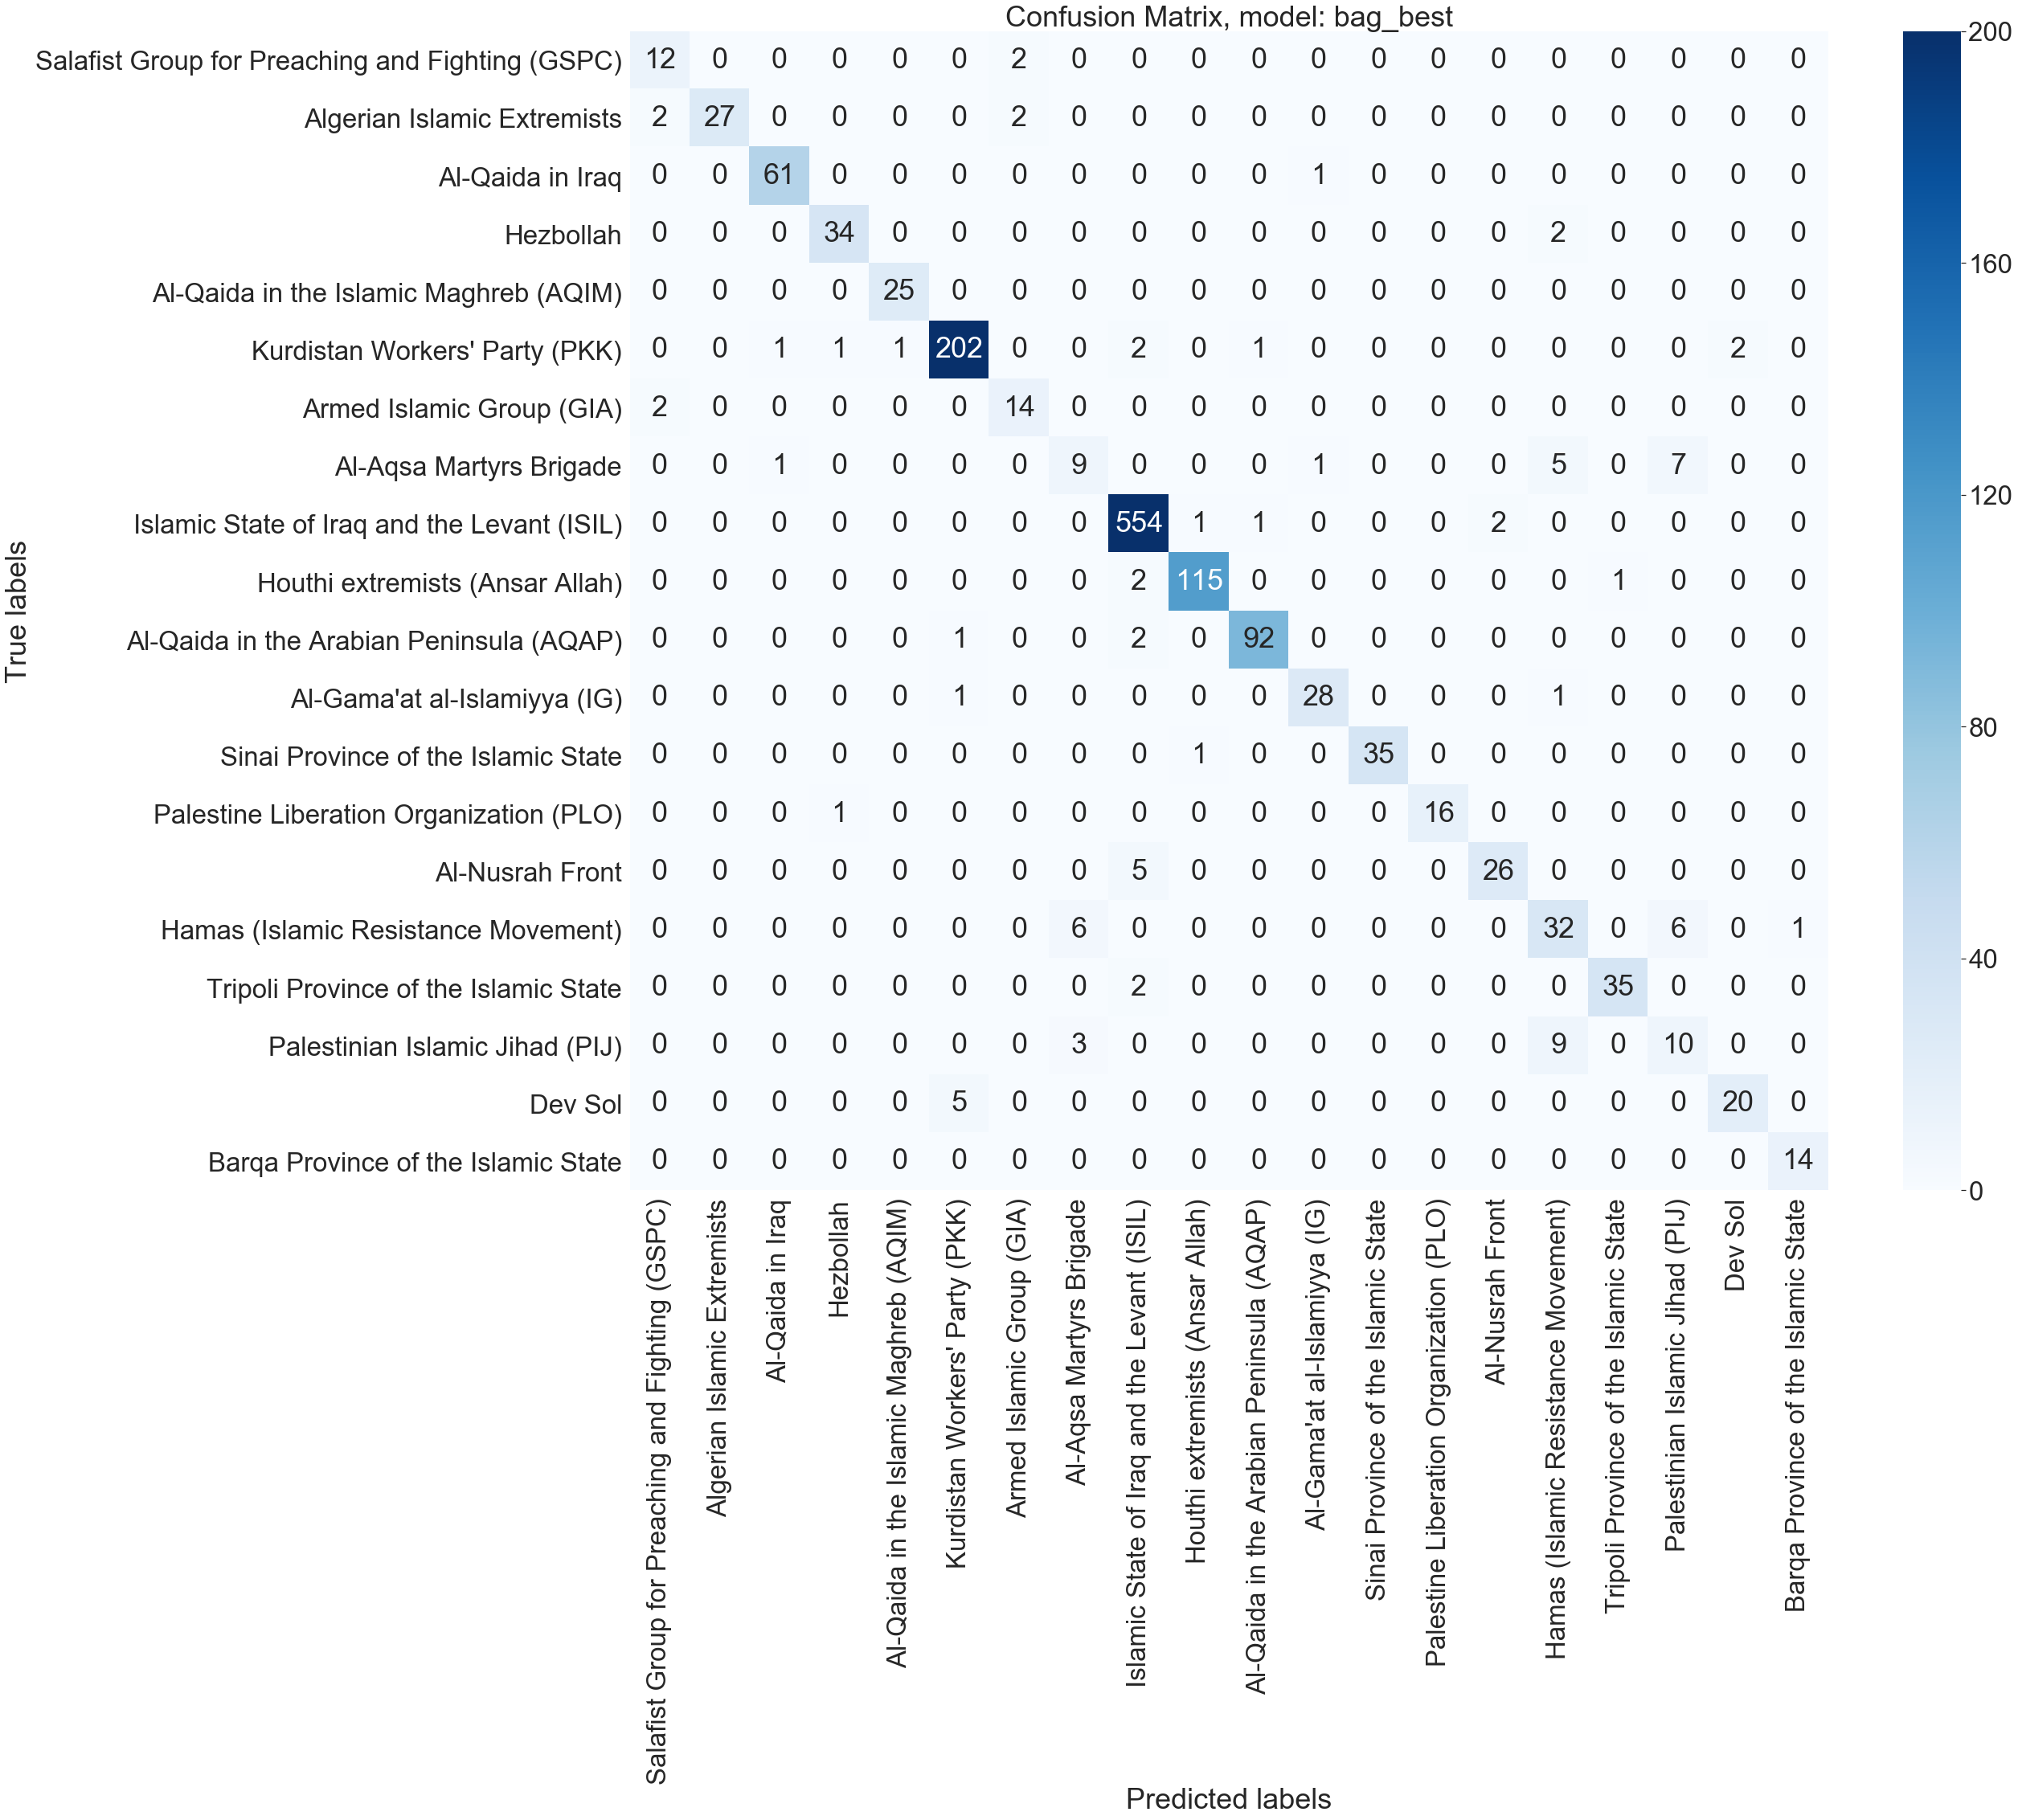

In [541]:
plot_confusion_matrix(top_model_final,X_eval.drop('eventid',axis=1),y_eval,vmaxnorm=200)

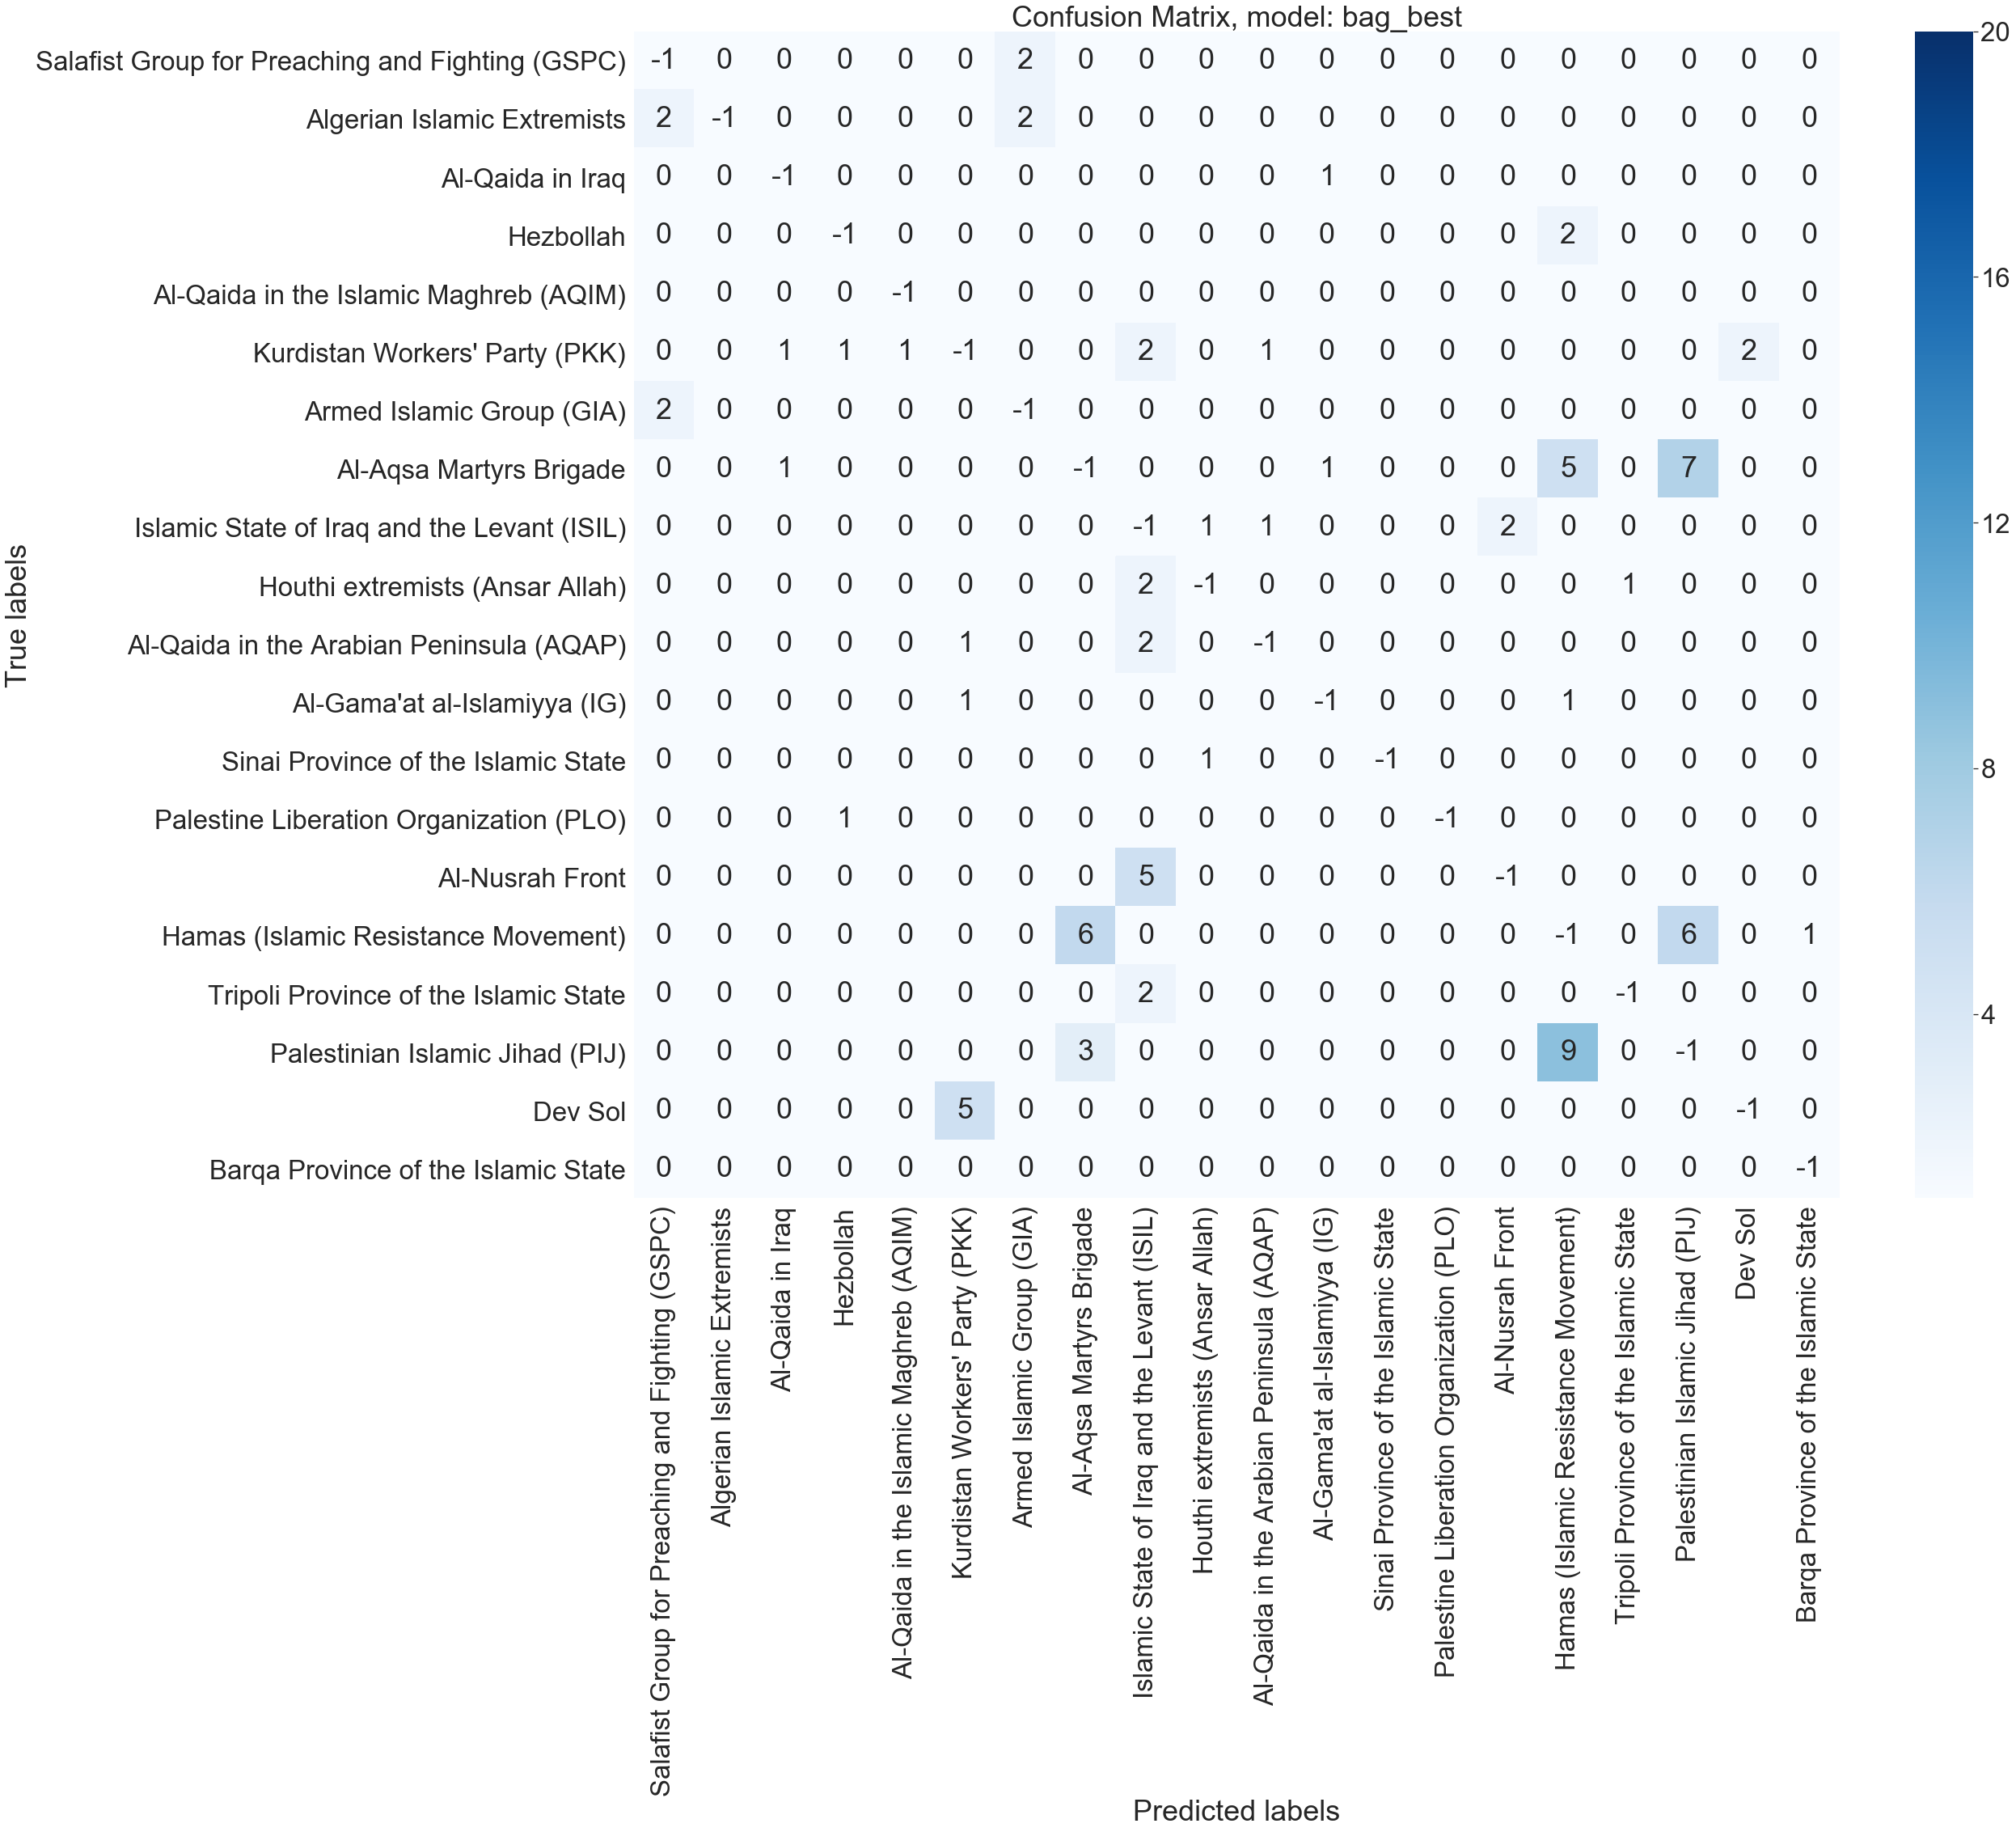

In [542]:
plot_confusion_matrix(top_model_final,X_eval.drop('eventid',axis=1),y_eval,vmaxneg=20,neg_out_diag=True)

##### Though some notable errors do still occur (as one might expect with real-world data such as this), suggesting that we would need to be careful in deployment in carefully weighting up and assessing the outputs of this model before using it as evidence to help inform anti-terror policy

## Deployment on unknowns

##### As per the stated goals of this project, the final task it to deploy this model on the genuinely unknown attacks in the Middle East. For this we select only attacks carried out in 2016 and 2017 as these would be most pertinent and valuable for policy makers to have better insights on if they are to make better policy decisions in the present

In [543]:
df_sample_clean_unknowns, target_definitions_unknowns = main_pipeline_features(df,region='Middle East & North Africa',
                                                                        nclasses=nclasses,
                                                                        msample_random_state=1,
                                                                        x_vars_int = x_vars_int,
                                                                        x_vars_ordered= x_vars_ordered,
                                                                        x_vars_cat = x_vars_cat,x_id=x_id,
                                                                        y_var=y_var,return_unknowns=True)

df_sample_clean_unknowns_recent = df_sample_clean_unknowns[(df_sample_clean_unknowns['iyear'] == 2016) |
                                                           (df_sample_clean_unknowns['iyear'] == 2017)]

clean dataframe created:  shape -  (29377, 27) number of NAs -  0


In [544]:
X_deployment_unknowns.columns

Index(['nkill', 'nwound', 'nperps', 'nperpcap', 'nkillter', 'iyear', 'imonth',
       'iday', 'country', 'attacktype1', 'targtype1', 'ransom', 'natlty1',
       'targsubtype1', 'suicide', 'provstate', 'claimmode', 'claimed',
       'multiple', 'guncertain1', 'INT_LOG', 'INT_MISC', 'INT_ANY', 'city',
       'eventid'],
      dtype='object')

In [555]:
X_deployment_unknowns = df_sample_clean_unknowns_recent[all_x_vars + ['eventid']]
y_deployment_pred = top_model_final.predict(X_deployment_unknowns)
y_deployment_pred_proba = top_model_final.predict_proba(X_deployment_unknowns)
y_deployment_pred_proba_max = [x.max() for x in y_deployment_pred_proba]

In [556]:
X.columns

Index(['nkill', 'nwound', 'nperps', 'nperpcap', 'nkillter', 'iyear', 'imonth',
       'iday', 'country', 'attacktype1', 'targtype1', 'ransom', 'natlty1',
       'targsubtype1', 'suicide', 'provstate', 'claimmode', 'claimed',
       'claimed', 'multiple', 'guncertain1', 'INT_LOG', 'INT_MISC', 'INT_ANY',
       'city', 'eventid'],
      dtype='object')

In [557]:
X_deployment_unknowns.columns

Index(['nkill', 'nwound', 'nperps', 'nperpcap', 'nkillter', 'iyear', 'imonth',
       'iday', 'country', 'attacktype1', 'targtype1', 'ransom', 'natlty1',
       'targsubtype1', 'suicide', 'provstate', 'claimmode', 'claimed',
       'multiple', 'guncertain1', 'INT_LOG', 'INT_MISC', 'INT_ANY', 'city',
       'eventid'],
      dtype='object')

In [558]:
target_label_dict = {}
for index,group in enumerate(target_definitions):
    target_label_dict[index] = group

In [559]:
df_deployment = df_sample_clean_unknowns_recent
df_deployment['predicted'] = y_deployment_pred
df_deployment['predicted'] = df_deployment['predicted'].map(target_label_dict)
df_deployment['predicted_prob_max'] = y_deployment_pred_proba_max
df_deployment['predicted_prob_max_threshold'] = df_deployment['predicted_prob_max']
df_deployment['predicted_prob_max_threshold'] = df_deployment['predicted_prob_max_threshold'].apply(lambda x: np.where(x < 0.51 ,np.nan,x))

##### While there is no way to objectively test if these predictions are correct (by definition) looking at the outputs is also helpful to 'common sense check' the results of the model. For example it seems there are no obvious bugs (such as all predictions being in one class) and – whilst there are quite a large amount in one group – this is proportional to the unbalanced country location of attacks, suggesting, as hypothesized, that location is a major predictive variable 

In [560]:
xout = df_deployment.groupby('predicted').count().reset_index().sort_values('eventid',ascending=False)
fig = plotly_bar_chart(xout,'predicted','eventid',xtitle = 'terrorist group',
                 ytitle='number of attacks',title='Distribution of attacks by group')   

iplot(fig)


In [561]:
df_deployment = df_deployment.merge(df[['eventid','country_txt']],on="eventid",how="left")
xout = df_deployment.groupby('country_txt').count().reset_index().sort_values('eventid',ascending=False)
fig = plotly_bar_chart(xout,'country_txt','eventid',xtitle = 'terrorist group',
                 ytitle='number of attacks',title='Distribution of attacks by country')   

iplot(fig)

##### Looking at the confidence level of predictions, then generally we find the model is quite confident in most cases, though to deploy this model in form policy we would need to define a threshold in line with the acceptable limit to help make policy decisions (e.g. >80%), in which case we would cut the threshold here

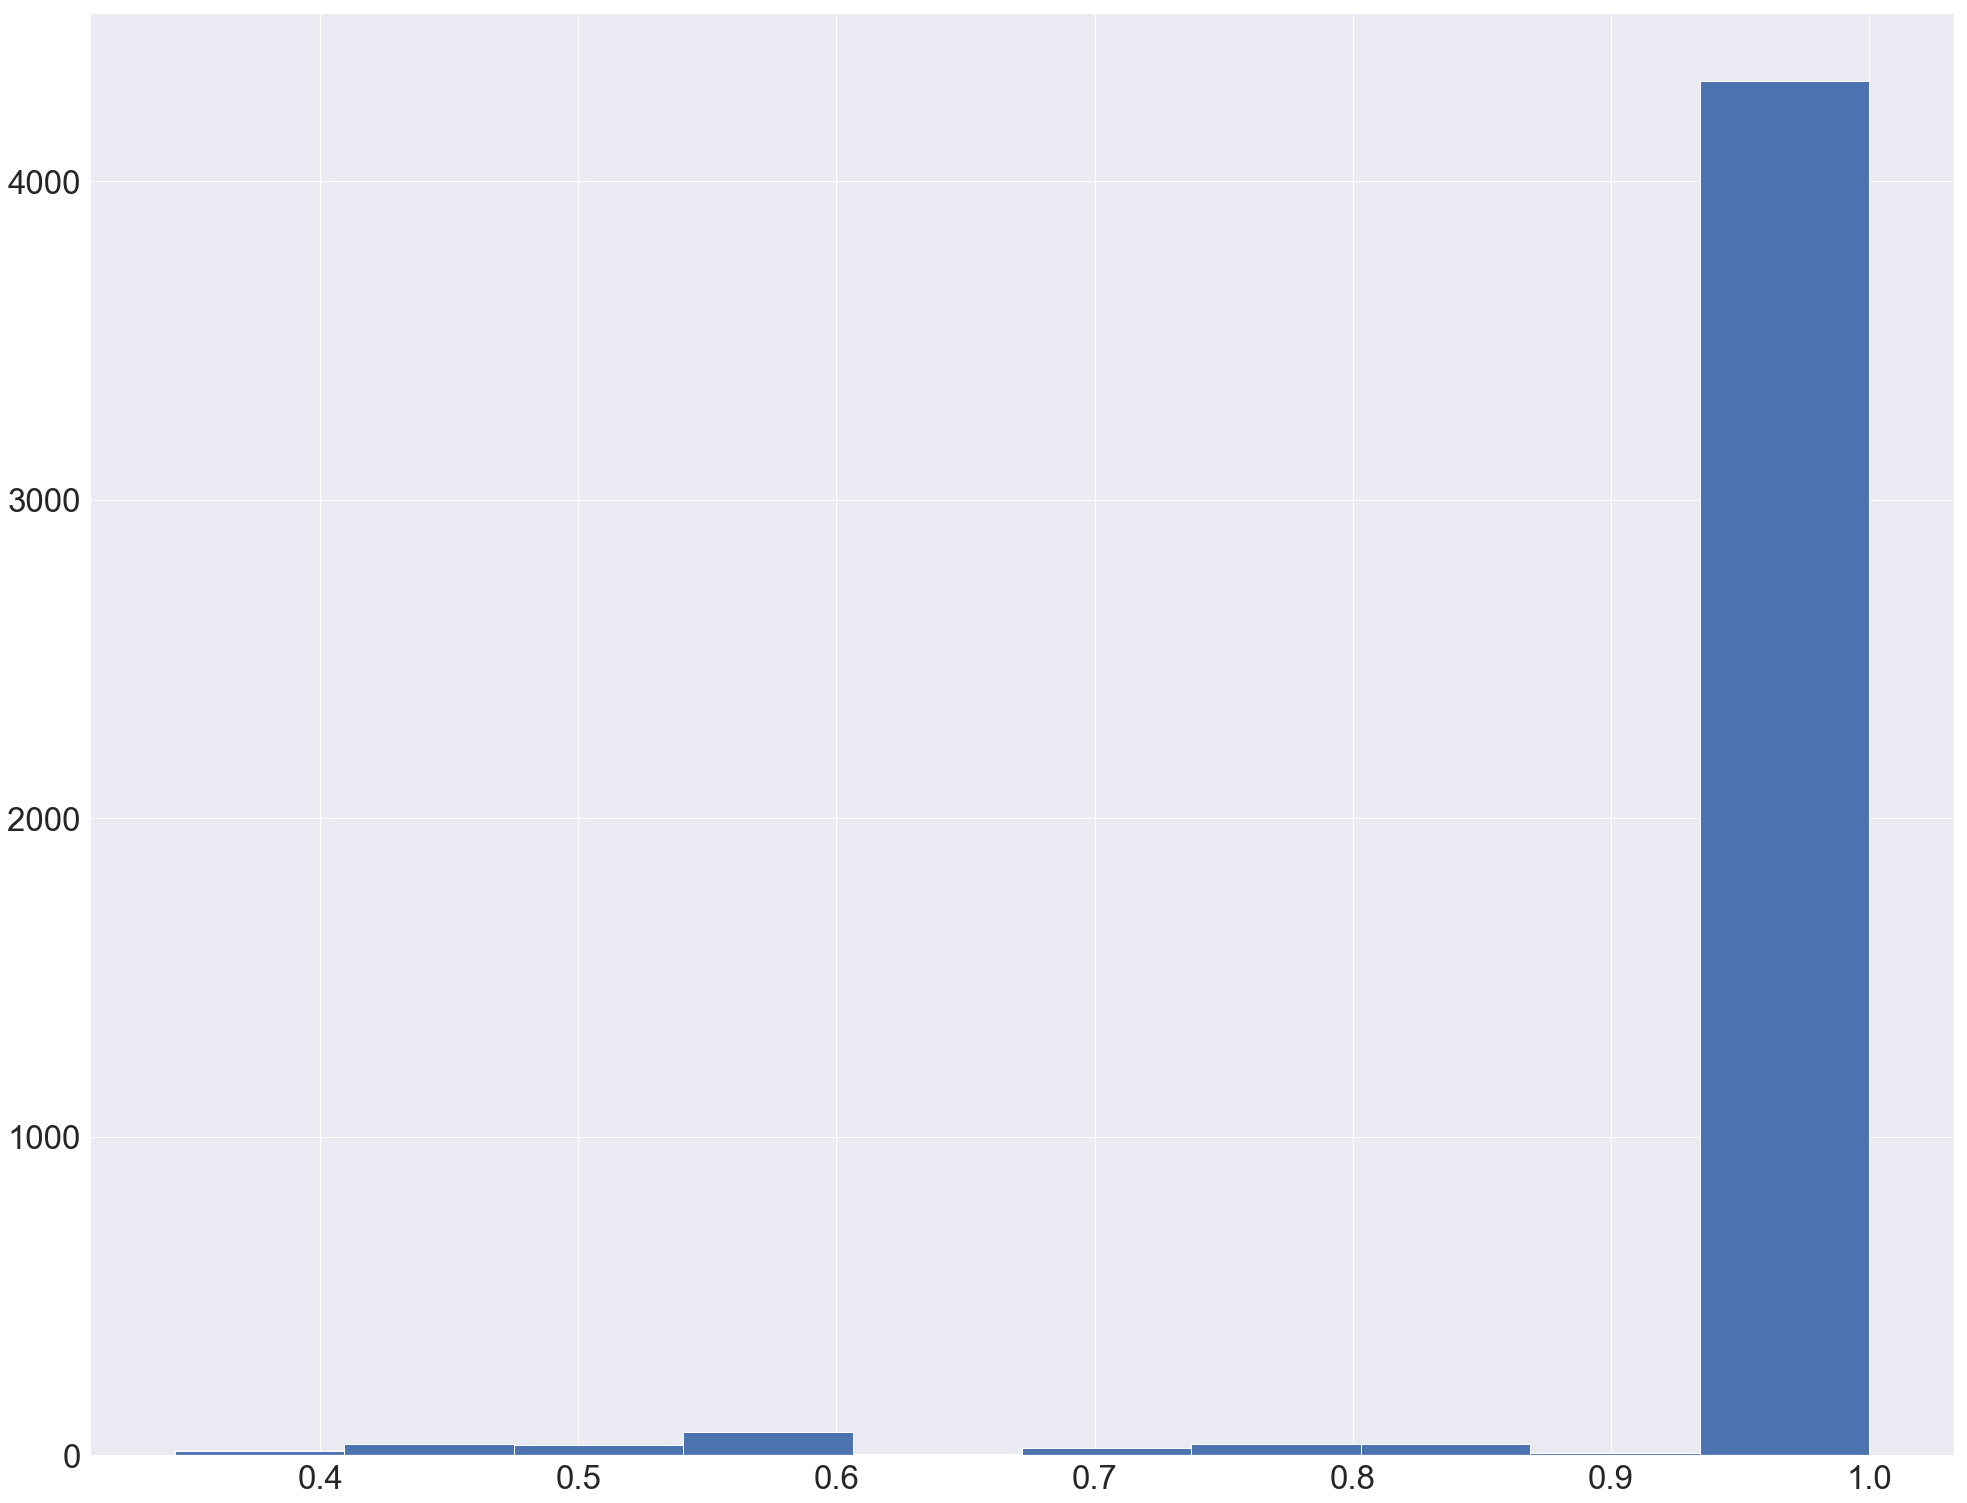

In [562]:
df_deployment['predicted_prob_max'].hist()

##### Finally we can save the outputs of the deployed model to csv for further analysis and potentially as an evidence input for policy discussion

In [563]:
df_deployment.to_csv('terror_group_predictions_middle_east_2016_2017.csv')

# Conclusions & Insights

* It is important to set clear real-world project goals in order to help define and focus down the technical aims of analysis 

* The strong link between group activity and locationality means geographic variables are very predictive and there is a good reason to make regionally specific models

* Given regional specificity it made sense for this analysis to focus on Middle East and North Africa due to a large number of attacks in the area suggesting the project may have most impact here 

* Given the disproportionate impact a small number of active groups have it made sense to also focus analysis onto these most active groups 

* For groups operating in the same geographic areas, cleaning and selecting other variables like nationality of victims attacked and method of attack proved significant discriminators

* Non-linear ensemble models worked well for this data set, likely due to their ability to deal well with unbalanced classes, the large number of possible variables, and the fact that many of these were categorical variables

* Using precision as the cost function for this problem makes sense as we want to be confident we are right if we are going to assign responsibility to a group to make potentially deadly policy decisions 

* Using NLP to create new features from text info on the attacks was only able to marginally improve results, though more work may be able to draw more signal out of this 

* Tuning model parameters was able to improve performance for the best performing ensemble method,  with results standing up well even to hidden evaluation sets the model has never seen before 

* This model could be deployed to help attribute responsibility for recent and new unknown attacks in the Middle East and could thus feed evidence for policy decisions in the area, such as which groups to target 
